<a href="https://colab.research.google.com/github/will-cotton4/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module3-generative-adversarial-networks/LS_DS_443_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 4 Lesson 3*

# Generative Adversarial Networks (GANs)


*PS: The person below does not exist*


<img src="https://thispersondoesnotexist.com/image" width=500>

# Lecture

Learning Objectives:
1. What is a GAN?
    - Describe the mechanisms of a Generator & Discriminator
    - Describe the Adverserial process
2. How does a GAN achieve good results?
    - Talk about relationship with Game Theory 
    - Illustrate NASH equilibrium

## GAN Overview
<img  src="https://github.com/will-cotton4/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module3-generative-adversarial-networks/GAN%20Overview.jpeg?raw=1" width=800>

<br></br>
<br></br>
<br></br>

## GAN Framework
<img  src="https://github.com/will-cotton4/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module3-generative-adversarial-networks/GAN%20Framework.jpeg?raw=1" width=800>

## *Two* neural networks - adversaries!

![Spy vs. Spy](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg/360px-Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg)

Generative Adversarial Networks is an approach to unsupervised learning, based on the insight that we can train *two* networks simultaneously and pit them against each other.

- The discriminator is trained with real - but unlabeled - data, and has the goal of identifying whether or not some new item belongs in it.
- The generator starts from noise (it doesn't see the data at all!), and tries to generate output to fool the discriminator (and gets to update based on feedback).

GANs can be considered a zero-sum game, in the [game theory](https://en.wikipedia.org/wiki/Game_theory) sense. Game theory is a common approach to modeling strategic competitive behavior between rational decision makers, and is heavily used in economics as well as computer science.

If you've also heard the hype about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), one way to understand it is:

```
Reinforcement Learning : GAN :: Decision Theory : Game Theory
```

That is, Reinforcement Learning is more closely analogous to [decision theory](https://en.wikipedia.org/wiki/Decision_theory), a relative to the field of game theory, featuring the behavior of an "agent" against "nature" (the environment). The agent is strategic and rational, but the environment simply is.

## A Foray into Game Theory

What is a "zero sum" game? It is a model of the interaction of two strategic agents, in a situation where, for one to gain, the other must lose, and vice-versa.

A famous example is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma). The typical story behind this game is something like this:

> Two criminals who committed a crime together are caught by the authorities. There is enough evidence to put them each away for 3 years, but the police interrogate them separately, and offer each of them a deal - "Tell us what the other criminal did, and we'll go lighter on you."

> The deal is tempting - the person who takes it shaves 2 years off their sentence. But, it adds 5 years to the sentence of the other person. So if both talk, they both get 3 - 2 + 5 = 6 years, twice as much if they both don't. But if one talks and the other doesn't, the talker gets 1 year and the non-talker gets 8!

> The result is, individually, they both prefer defecting (talking with the police) regardless of what the other person does. But, they'd both be better off if they could somehow trust one another to not talk to the police.

Mathematically, we consider this outcome a *Nash equilibrium* - a stable situation where neither player would want to unilaterally change strategy. But, it's one where a *pareto superior* outcome exists (an outcome that both players would prefer to what they have now).

An illustration (with different numbers) of the Prisoner's Dilemma:

![Prisoner's Dilemmat](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Dilema_do_Prisioneiro.png/480px-Dilema_do_Prisioneiro.png)

More generally, these could be referred to as "constant sum" games - "zero sum" implies that for any player to get ahead, the other must inevitably end up behind. The above illustration could be of a game where people are "splitting loot", and so everybody *gets* something - it's just that some get more than others. The utility can be normalized so it sums to zero, or any other constant.

Game Theory is one of the core tools used in social science and other areas to model and explain behavior. The main path to overcome "dilemmas" is *iteration* - through repetition, players can have a reputation, and value that reputation more than the outcome in any single round. For example, think of the lengths some restaurants take to ensure positive reviews.

*Exercise* - think of at least two scenarios that could be explained with Prisoner's Dilemma, and of one other scenario that you think could also be modeled as some sort of strategic game between agents.

## Minimum Viable GAN

Courtesy of Keras:

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

In [0]:
np.random.seed(10)
random_dim = 100
 
def load_minst_data():
    # load the data - we'll use Fashion MNIST, for a change of pace
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [0]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

4423680/4422102 [==============================] - 2s 0us/step


W0724 16:07:09.035647 140644505704320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 16:07:09.037598 140644505704320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 16:07:09.040243 140644505704320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0724 16:07:09.061084 140644505704320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 16:07:09.101179 140644505704320 deprecation_wra

--------------- Epoch 1 ---------------


  1%|          | 8/937 [00:00<00:11, 77.48it/s]

--------------- Epoch 2 ---------------


  1%|          | 9/937 [00:00<00:10, 86.59it/s]

--------------- Epoch 3 ---------------


  1%|          | 10/937 [00:00<00:09, 94.17it/s]

--------------- Epoch 4 ---------------


  1%|          | 10/937 [00:00<00:10, 90.57it/s]

--------------- Epoch 5 ---------------


  1%|          | 9/937 [00:00<00:10, 88.51it/s]

--------------- Epoch 6 ---------------


  1%|          | 9/937 [00:00<00:10, 89.19it/s]

--------------- Epoch 7 ---------------


  1%|          | 10/937 [00:00<00:09, 93.23it/s]

--------------- Epoch 8 ---------------


  1%|          | 10/937 [00:00<00:10, 92.50it/s]

--------------- Epoch 9 ---------------


  1%|          | 9/937 [00:00<00:10, 89.65it/s]

--------------- Epoch 10 ---------------


  1%|          | 10/937 [00:00<00:09, 95.08it/s]

--------------- Epoch 11 ---------------


  1%|          | 9/937 [00:00<00:10, 89.92it/s]

--------------- Epoch 12 ---------------


  1%|          | 9/937 [00:00<00:10, 85.82it/s]

--------------- Epoch 13 ---------------


  1%|          | 8/937 [00:00<00:11, 79.66it/s]

--------------- Epoch 14 ---------------


  1%|          | 10/937 [00:00<00:10, 92.15it/s]

--------------- Epoch 15 ---------------


  1%|          | 9/937 [00:00<00:10, 86.60it/s]

--------------- Epoch 16 ---------------


  1%|          | 10/937 [00:00<00:09, 95.49it/s]

--------------- Epoch 17 ---------------


  1%|          | 10/937 [00:00<00:09, 93.13it/s]

--------------- Epoch 18 ---------------


  1%|          | 9/937 [00:00<00:10, 88.71it/s]

--------------- Epoch 19 ---------------


  1%|          | 9/937 [00:00<00:10, 88.29it/s]

--------------- Epoch 20 ---------------


  1%|          | 8/937 [00:00<00:11, 79.21it/s]

--------------- Epoch 21 ---------------


  1%|          | 10/937 [00:00<00:10, 92.05it/s]

--------------- Epoch 22 ---------------


  1%|          | 10/937 [00:00<00:10, 91.31it/s]

--------------- Epoch 23 ---------------


  1%|          | 9/937 [00:00<00:10, 86.24it/s]

--------------- Epoch 24 ---------------


  1%|          | 9/937 [00:00<00:10, 86.22it/s]

--------------- Epoch 25 ---------------


  1%|          | 9/937 [00:00<00:10, 85.48it/s]

--------------- Epoch 26 ---------------


  1%|          | 10/937 [00:00<00:09, 95.64it/s]

--------------- Epoch 27 ---------------


  1%|          | 10/937 [00:00<00:10, 92.47it/s]

--------------- Epoch 28 ---------------


  1%|          | 10/937 [00:00<00:10, 92.49it/s]

--------------- Epoch 29 ---------------


  1%|          | 9/937 [00:00<00:10, 88.04it/s]

--------------- Epoch 30 ---------------


  1%|          | 10/937 [00:00<00:09, 95.46it/s]

--------------- Epoch 31 ---------------


  1%|          | 10/937 [00:00<00:10, 91.83it/s]

--------------- Epoch 32 ---------------


  1%|          | 9/937 [00:00<00:10, 89.84it/s]

--------------- Epoch 33 ---------------


  1%|          | 11/937 [00:00<00:09, 100.98it/s]

--------------- Epoch 34 ---------------


  1%|          | 10/937 [00:00<00:10, 91.35it/s]

--------------- Epoch 35 ---------------


  1%|          | 10/937 [00:00<00:10, 92.50it/s]

--------------- Epoch 36 ---------------


  1%|          | 9/937 [00:00<00:10, 85.08it/s]

--------------- Epoch 37 ---------------


  1%|          | 10/937 [00:00<00:09, 93.94it/s]

--------------- Epoch 38 ---------------


  1%|          | 10/937 [00:00<00:09, 98.27it/s]

--------------- Epoch 39 ---------------


  1%|          | 10/937 [00:00<00:09, 98.46it/s]

--------------- Epoch 40 ---------------


100%|██████████| 937/937 [00:09<00:00, 94.69it/s]


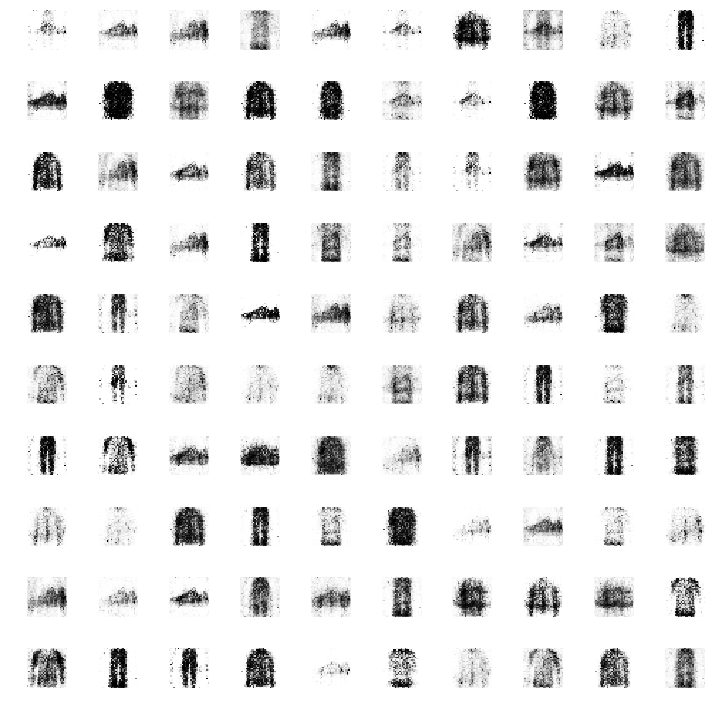

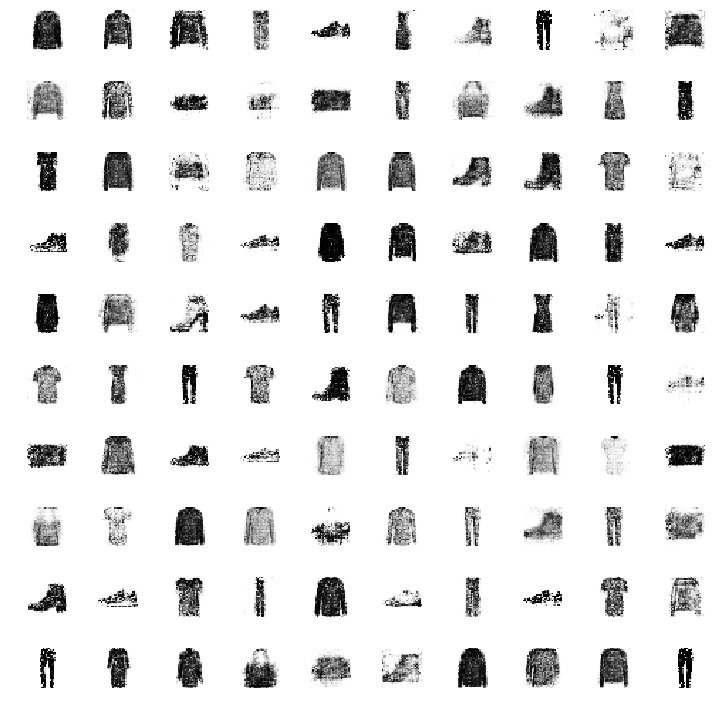

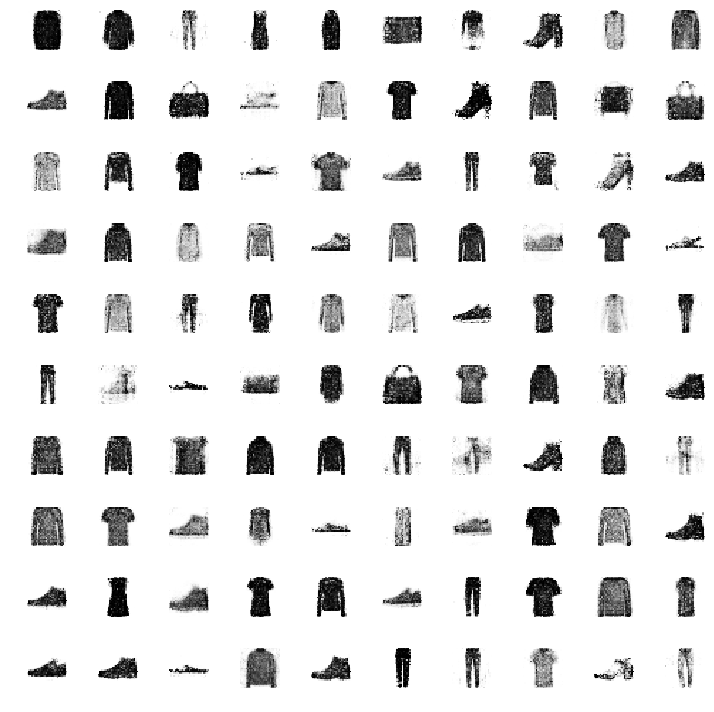

In [4]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
 
train(40, 64)

Pretty decent results, even after not too many iterations.

We can do even better, with pretrained StyleGAN!

## StyleGAN - A Style-Based Generator Architecture for Generative Adversarial Networks

Original paper: https://arxiv.org/abs/1812.04948

Source code: https://github.com/NVlabs/stylegan

Many applications:
- https://thispersondoesnotexist.com
- https://thiscatdoesnotexist.com
- https://thisairbnbdoesnotexist.com
- https://stackroboflow.com

In [5]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan/

Cloning into 'stylegan'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (77/77), done.
/content/stylegan


In [6]:
# From stylegan/pretrained_example.py

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

def main():
    # Initialize TensorFlow.
    tflib.init_tf()

    # Load pre-trained network.
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    # Print network details.
    Gs.print_layers()

    # Pick latent vector.
    rnd = np.random.RandomState(5)
    latents = rnd.randn(1, Gs.input_shape[1])

    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

    # Save image.
    os.makedirs(config.result_dir, exist_ok=True)
    png_filename = os.path.join(config.result_dir, 'example.png')
    PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

main()


Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

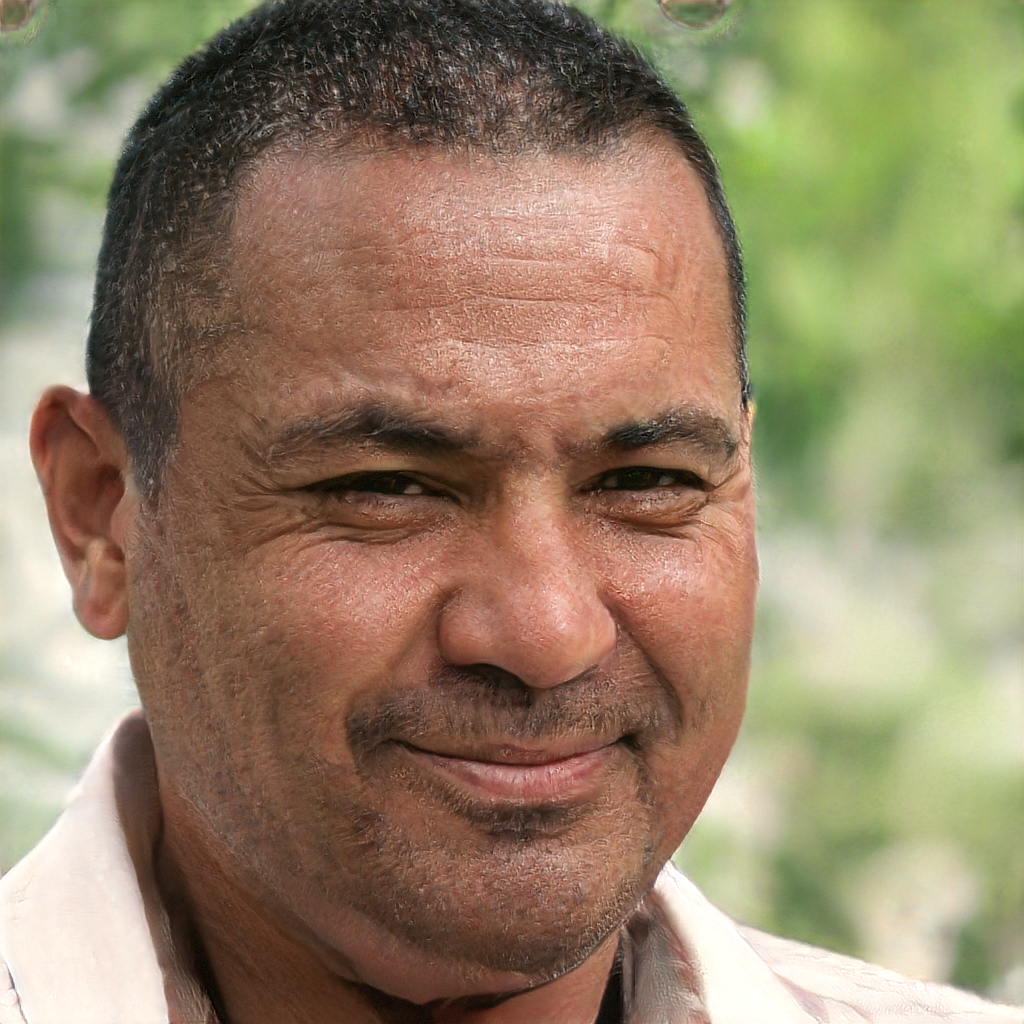

In [7]:
from IPython.display import Image
Image(filename='results/example.png')

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [8]:
!pip install emoji_data_python

     |████████████████████████████████| 81kB 27.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/ce/50/87/ae01673e45b9bd9c826a1b868a0e5a6b856e2e52cdf0f81c0d
Successfully built emoji-data-python


In [9]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

--2019-07-24 16:15:00--  https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip [following]
--2019-07-24 16:15:01--  https://github.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip [following]
--2019-07-24 16:15:01--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/master/

In [0]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [11]:
example_emoji.shape

(28, 28, 4)

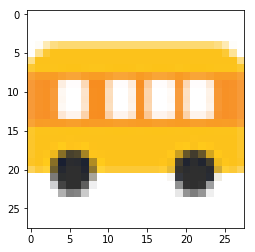

In [12]:
plt.imshow(example_emoji);

In [13]:
grayscale_emoji.shape

(28, 28)

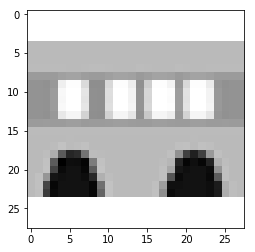

In [14]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.09it/s]

--------------- Epoch 10 ---------------



  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------
--------------- Epoch 16 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------
--------------- Epoch 18 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------
--------------- Epoch 20 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 21 ---------------
--------------- Epoch 22 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------
--------------- Epoch 24 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------
--------------- Epoch 26 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------
--------------- Epoch 28 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------
--------------- Epoch 30 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------
--------------- Epoch 32 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------
--------------- Epoch 34 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------
--------------- Epoch 36 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------
--------------- Epoch 38 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------
--------------- Epoch 40 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 41 ---------------
--------------- Epoch 42 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------
--------------- Epoch 44 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------
--------------- Epoch 46 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------
--------------- Epoch 48 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------
--------------- Epoch 50 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 51 ---------------
--------------- Epoch 52 ---------------


 62%|██████▏   | 8/13 [00:00<00:00, 70.92it/s]

--------------- Epoch 53 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------
--------------- Epoch 55 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------
--------------- Epoch 57 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------
--------------- Epoch 59 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------
--------------- Epoch 61 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------
--------------- Epoch 63 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------
--------------- Epoch 65 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------
--------------- Epoch 67 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------
--------------- Epoch 69 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------
--------------- Epoch 71 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------
--------------- Epoch 73 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 74 ---------------
--------------- Epoch 75 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------
--------------- Epoch 77 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 78 ---------------
--------------- Epoch 79 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------
--------------- Epoch 81 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 82 ---------------
--------------- Epoch 83 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------
--------------- Epoch 85 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------
--------------- Epoch 87 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------
--------------- Epoch 89 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------
--------------- Epoch 91 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------
--------------- Epoch 93 ---------------


 62%|██████▏   | 8/13 [00:00<00:00, 72.83it/s]

--------------- Epoch 94 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------
--------------- Epoch 96 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------
--------------- Epoch 98 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 99 ---------------
--------------- Epoch 100 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.94it/s]

--------------- Epoch 101 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 102 ---------------
--------------- Epoch 103 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 104 ---------------
--------------- Epoch 105 ---------------


100%|██████████| 13/13 [00:00<00:00, 65.63it/s]

--------------- Epoch 106 ---------------



  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 107 ---------------
--------------- Epoch 108 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 109 ---------------
--------------- Epoch 110 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 111 ---------------
--------------- Epoch 112 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 113 ---------------
--------------- Epoch 114 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 115 ---------------
--------------- Epoch 116 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 117 ---------------
--------------- Epoch 118 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 119 ---------------
--------------- Epoch 120 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 121 ---------------
--------------- Epoch 122 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 123 ---------------
--------------- Epoch 124 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 125 ---------------
--------------- Epoch 126 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 127 ---------------
--------------- Epoch 128 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 129 ---------------
--------------- Epoch 130 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 131 ---------------
--------------- Epoch 132 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 133 ---------------
--------------- Epoch 134 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 135 ---------------
--------------- Epoch 136 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 137 ---------------
--------------- Epoch 138 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 139 ---------------
--------------- Epoch 140 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 141 ---------------
--------------- Epoch 142 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 143 ---------------
--------------- Epoch 144 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 145 ---------------
--------------- Epoch 146 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 147 ---------------
--------------- Epoch 148 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 149 ---------------
--------------- Epoch 150 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 151 ---------------
--------------- Epoch 152 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 153 ---------------
--------------- Epoch 154 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.59it/s]


--------------- Epoch 155 ---------------
---------------

  0%|          | 0/13 [00:00<?, ?it/s]

 Epoch 156 ---------------
--------------- Epoch 157 ---------------
--------------- Epoch 158 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 159 ---------------
--------------- Epoch 160 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 161 ---------------
--------------- Epoch 162 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 163 ---------------
--------------- Epoch 164 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 165 ---------------
--------------- Epoch 166 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 167 ---------------
--------------- Epoch 168 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 169 ---------------
--------------- Epoch 170 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 171 ---------------
--------------- Epoch 172 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 173 ---------------
--------------- Epoch 174 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 175 ---------------
--------------- Epoch 176 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 177 ---------------
--------------- Epoch 178 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 179 ---------------
--------------- Epoch 180 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 181 ---------------
--------------- Epoch 182 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 183 ---------------
--------------- Epoch 184 ---------------


100%|██████████| 13/13 [00:00<00:00, 65.70it/s]

--------------- Epoch 185 ---------------



  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 186 ---------------
--------------- Epoch 187 ---------------
--------------- Epoch 188 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 189 ---------------
--------------- Epoch 190 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 191 ---------------
--------------- Epoch 192 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 193 ---------------
--------------- Epoch 194 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 195 ---------------
--------------- Epoch 196 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 197 ---------------
--------------- Epoch 198 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 199 ---------------
--------------- Epoch 200 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.55it/s]

--------------- Epoch 201 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.25it/s]


--------------- Epoch 202 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 203 ---------------
--------------- Epoch 204 ---------------
--------------- Epoch 205 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.11it/s]

--------------- Epoch 206 ---------------



  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 207 ---------------
--------------- Epoch 208 ---------------
--------------- Epoch 209 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 210 ---------------
--------------- Epoch 211 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 212 ---------------
--------------- Epoch 213 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 214 ---------------
--------------- Epoch 215 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 216 ---------------
--------------- Epoch 217 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 218 ---------------
--------------- Epoch 219 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 220 ---------------
--------------- Epoch 221 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 222 ---------------
--------------- Epoch 223 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 224 ---------------
--------------- Epoch 225 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 226 ---------------
--------------- Epoch 227 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 228 ---------------
--------------- Epoch 229 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 230 ---------------
--------------- Epoch 231 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 232 ---------------
--------------- Epoch 233 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 234 ---------------
--------------- Epoch 235 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 236 ---------------
--------------- Epoch 237 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 238 ---------------
--------------- Epoch 239 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 240 ---------------
--------------- Epoch 241 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 242 ---------------
--------------- Epoch 243 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 244 ---------------
--------------- Epoch 245 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 246 ---------------
--------------- Epoch 247 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 248 ---------------
--------------- Epoch 249 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 250 ---------------
--------------- Epoch 251 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 252 ---------------
--------------- Epoch 253 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 254 ---------------
--------------- Epoch 255 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 256 ---------------
--------------- Epoch 257 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 258 ---------------
--------------- Epoch 259 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 260 ---------------
--------------- Epoch 261 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 262 ---------------
--------------- Epoch 263 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 264 ---------------
--------------- Epoch 265 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 266 ---------------
--------------- Epoch 267 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 268 ---------------
--------------- Epoch 269 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 270 ---------------
--------------- Epoch 271 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 272 ---------------
--------------- Epoch 273 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 274 ---------------
--------------- Epoch 275 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 276 ---------------
--------------- Epoch 277 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 278 ---------------
--------------- Epoch 279 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 280 ---------------
--------------- Epoch 281 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 282 ---------------
--------------- Epoch 283 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 284 ---------------
--------------- Epoch 285 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 286 ---------------
--------------- Epoch 287 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 288 ---------------
--------------- Epoch 289 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 290 ---------------
--------------- Epoch 291 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 292 ---------------
--------------- Epoch 293 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 294 ---------------
--------------- Epoch 295 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 296 ---------------
--------------- Epoch 297 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 298 ---------------
--------------- Epoch 299 ---------------


100%|██████████| 13/13 [00:00<00:00, 72.92it/s]


--------------- Epoch 300 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 65.71it/s]

--------------- Epoch 301 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 302 ---------------
--------------- Epoch 303 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 304 ---------------
--------------- Epoch 305 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 306 ---------------
--------------- Epoch 307 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 308 ---------------
--------------- Epoch 309 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 310 ---------------
--------------- Epoch 311 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 312 ---------------
--------------- Epoch 313 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 314 ---------------
--------------- Epoch 315 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 316 ---------------
--------------- Epoch 317 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 318 ---------------
--------------- Epoch 319 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.62it/s]

--------------- Epoch 320 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 321 ---------------
--------------- Epoch 322 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 323 ---------------
--------------- Epoch 324 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 325 ---------------
--------------- Epoch 326 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 327 ---------------
--------------- Epoch 328 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 329 ---------------
--------------- Epoch 330 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 331 ---------------
--------------- Epoch 332 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 333 ---------------
--------------- Epoch 334 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 335 ---------------
--------------- Epoch 336 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 337 ---------------
--------------- Epoch 338 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 339 ---------------
--------------- Epoch 340 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 341 ---------------
--------------- Epoch 342 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 343 ---------------
--------------- Epoch 344 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 345 ---------------
--------------- Epoch 346 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 347 ---------------
--------------- Epoch 348 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 349 ---------------
--------------- Epoch 350 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 351 ---------------
--------------- Epoch 352 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 353 ---------------
--------------- Epoch 354 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 355 ---------------
--------------- Epoch 356 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 357 ---------------
--------------- Epoch 358 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 359 ---------------
--------------- Epoch 360 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 361 ---------------
--------------- Epoch 362 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 363 ---------------
--------------- Epoch 364 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 365 ---------------
--------------- Epoch 366 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 367 ---------------
--------------- Epoch 368 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 369 ---------------
--------------- Epoch 370 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 371 ---------------
--------------- Epoch 372 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 373 ---------------
--------------- Epoch 374 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 375 ---------------
--------------- Epoch 376 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 377 ---------------
--------------- Epoch 378 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 379 ---------------
--------------- Epoch 380 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 381 ---------------
--------------- Epoch 382 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 383 ---------------
--------------- Epoch 384 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 385 ---------------
--------------- Epoch 386 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 387 ---------------
--------------- Epoch 388 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 389 ---------------
--------------- Epoch 390 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 391 ---------------
--------------- Epoch 392 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 393 ---------------
--------------- Epoch 394 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 395 ---------------
--------------- Epoch 396 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 397 ---------------
--------------- Epoch 398 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 399 ---------------
--------------- Epoch 400 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.13it/s]

--------------- Epoch 401 ---------------



  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 402 ---------------
--------------- Epoch 403 ---------------
--------------- Epoch 404 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.43it/s]


--------------- Epoch 405 ---------------
---------------

 62%|██████▏   | 8/13 [00:00<00:00, 69.69it/s]

 Epoch 406 ---------------
--------------- Epoch 407 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.72it/s]

--------------- Epoch 408 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.81it/s]

--------------- Epoch 409 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 410 ---------------
--------------- Epoch 411 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 412 ---------------
--------------- Epoch 413 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 414 ---------------
--------------- Epoch 415 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 416 ---------------
--------------- Epoch 417 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 418 ---------------
--------------- Epoch 419 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 420 ---------------
--------------- Epoch 421 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 422 ---------------
--------------- Epoch 423 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 424 ---------------
--------------- Epoch 425 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 426 ---------------
--------------- Epoch 427 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 428 ---------------
--------------- Epoch 429 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 430 ---------------
--------------- Epoch 431 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 432 ---------------
--------------- Epoch 433 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 434 ---------------
--------------- Epoch 435 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 436 ---------------
--------------- Epoch 437 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 438 ---------------
--------------- Epoch 439 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 440 ---------------
--------------- Epoch 441 ---------------


100%|██████████| 13/13 [00:00<00:00, 66.94it/s]


--------------- Epoch 442 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 443 ---------------
--------------- Epoch 444 ---------------
--------------- Epoch 445 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 446 ---------------
--------------- Epoch 447 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 448 ---------------
--------------- Epoch 449 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 450 ---------------
--------------- Epoch 451 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 452 ---------------
--------------- Epoch 453 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 454 ---------------
--------------- Epoch 455 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 456 ---------------
--------------- Epoch 457 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 458 ---------------
--------------- Epoch 459 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 460 ---------------
--------------- Epoch 461 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 462 ---------------
--------------- Epoch 463 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 464 ---------------
--------------- Epoch 465 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 466 ---------------
--------------- Epoch 467 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 468 ---------------
--------------- Epoch 469 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 470 ---------------
--------------- Epoch 471 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 472 ---------------
--------------- Epoch 473 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 474 ---------------
--------------- Epoch 475 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 476 ---------------
--------------- Epoch 477 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 478 ---------------
--------------- Epoch 479 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 480 ---------------
--------------- Epoch 481 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 482 ---------------
--------------- Epoch 483 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 484 ---------------
--------------- Epoch 485 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 486 ---------------
--------------- Epoch 487 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 488 ---------------
--------------- Epoch 489 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 490 ---------------
--------------- Epoch 491 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 492 ---------------
--------------- Epoch 493 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 494 ---------------
--------------- Epoch 495 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 496 ---------------
--------------- Epoch 497 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 498 ---------------
--------------- Epoch 499 ---------------


100%|██████████| 13/13 [00:00<00:00, 72.67it/s]


--------------- Epoch 500 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 501 ---------------
--------------- Epoch 502 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 503 ---------------
--------------- Epoch 504 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 505 ---------------
--------------- Epoch 506 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 507 ---------------
--------------- Epoch 508 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 509 ---------------
--------------- Epoch 510 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 511 ---------------
--------------- Epoch 512 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 513 ---------------
--------------- Epoch 514 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 515 ---------------
--------------- Epoch 516 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 517 ---------------
--------------- Epoch 518 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 519 ---------------
--------------- Epoch 520 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 521 ---------------
--------------- Epoch 522 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 523 ---------------
--------------- Epoch 524 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 525 ---------------
--------------- Epoch 526 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 527 ---------------
--------------- Epoch 528 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 529 ---------------
--------------- Epoch 530 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 531 ---------------
--------------- Epoch 532 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 533 ---------------
--------------- Epoch 534 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 535 ---------------
--------------- Epoch 536 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 537 ---------------
--------------- Epoch 538 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 539 ---------------
--------------- Epoch 540 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 541 ---------------
--------------- Epoch 542 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 543 ---------------
--------------- Epoch 544 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 545 ---------------
--------------- Epoch 546 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 547 ---------------
--------------- Epoch 548 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 549 ---------------
--------------- Epoch 550 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 551 ---------------
--------------- Epoch 552 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 553 ---------------
--------------- Epoch 554 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 555 ---------------
--------------- Epoch 556 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 557 ---------------
--------------- Epoch 558 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 559 ---------------
--------------- Epoch 560 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 561 ---------------
--------------- Epoch 562 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.54it/s]

--------------- Epoch 563 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 564 ---------------
--------------- Epoch 565 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 566 ---------------
--------------- Epoch 567 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 63.42it/s]

--------------- Epoch 568 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 569 ---------------
--------------- Epoch 570 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 571 ---------------
--------------- Epoch 572 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 573 ---------------
--------------- Epoch 574 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 575 ---------------
--------------- Epoch 576 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 577 ---------------
--------------- Epoch 578 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 579 ---------------
--------------- Epoch 580 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 581 ---------------
--------------- Epoch 582 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 583 ---------------
--------------- Epoch 584 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 585 ---------------
--------------- Epoch 586 ---------------


100%|██████████| 13/13 [00:00<00:00, 65.73it/s]


--------------- Epoch 587 ---------------
--------------- Epoch 588 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 589 ---------------
--------------- Epoch 590 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 591 ---------------
--------------- Epoch 592 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 593 ---------------
--------------- Epoch 594 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 595 ---------------
--------------- Epoch 596 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 597 ---------------
--------------- Epoch 598 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 599 ---------------
--------------- Epoch 600 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 601 ---------------
--------------- Epoch 602 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.77it/s]

--------------- Epoch 603 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 604 ---------------
--------------- Epoch 605 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 606 ---------------
--------------- Epoch 607 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 608 ---------------
--------------- Epoch 609 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 610 ---------------
--------------- Epoch 611 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 612 ---------------
--------------- Epoch 613 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 614 ---------------
--------------- Epoch 615 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 616 ---------------
--------------- Epoch 617 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 618 ---------------
--------------- Epoch 619 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 620 ---------------
--------------- Epoch 621 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 622 ---------------
--------------- Epoch 623 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 624 ---------------
--------------- Epoch 625 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 626 ---------------
--------------- Epoch 627 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 628 ---------------
--------------- Epoch 629 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 630 ---------------
--------------- Epoch 631 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 632 ---------------
--------------- Epoch 633 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 634 ---------------
--------------- Epoch 635 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 636 ---------------
--------------- Epoch 637 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 638 ---------------
--------------- Epoch 639 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 640 ---------------
--------------- Epoch 641 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 642 ---------------
--------------- Epoch 643 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 644 ---------------
--------------- Epoch 645 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 646 ---------------
--------------- Epoch 647 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 648 ---------------
--------------- Epoch 649 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 650 ---------------
--------------- Epoch 651 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 652 ---------------
--------------- Epoch 653 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 654 ---------------
--------------- Epoch 655 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 656 ---------------
--------------- Epoch 657 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 658 ---------------
--------------- Epoch 659 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 660 ---------------
--------------- Epoch 661 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 662 ---------------
--------------- Epoch 663 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 664 ---------------
--------------- Epoch 665 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 666 ---------------
--------------- Epoch 667 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 668 ---------------
--------------- Epoch 669 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 670 ---------------
--------------- Epoch 671 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 672 ---------------
--------------- Epoch 673 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 674 ---------------
--------------- Epoch 675 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 676 ---------------
--------------- Epoch 677 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 678 ---------------
--------------- Epoch 679 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 680 ---------------
--------------- Epoch 681 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 682 ---------------
--------------- Epoch 683 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 684 ---------------
--------------- Epoch 685 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 686 ---------------
--------------- Epoch 687 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 688 ---------------
--------------- Epoch 689 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 690 ---------------
--------------- Epoch 691 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 692 ---------------
--------------- Epoch 693 ---------------


 54%|█████▍    | 7/13 [00:00<00:00, 61.63it/s]

--------------- Epoch 694 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 695 ---------------
--------------- Epoch 696 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 697 ---------------
--------------- Epoch 698 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 699 ---------------
--------------- Epoch 700 ---------------


100%|██████████| 13/13 [00:00<00:00, 65.88it/s]

--------------- Epoch 701 ---------------
--------------- Epoch 702


  0%|          | 0/13 [00:00<?, ?it/s]

 ---------------
--------------- Epoch 703 ---------------
--------------- Epoch 704 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 705 ---------------
--------------- Epoch 706 ---------------


100%|██████████| 13/13 [00:00<00:00, 65.32it/s]

--------------- Epoch 707 ---------------



  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 708 ---------------
--------------- Epoch 709 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 710 ---------------
--------------- Epoch 711 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 712 ---------------
--------------- Epoch 713 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 714 ---------------
--------------- Epoch 715 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 716 ---------------
--------------- Epoch 717 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 718 ---------------
--------------- Epoch 719 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 720 ---------------
--------------- Epoch 721 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 722 ---------------
--------------- Epoch 723 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 724 ---------------
--------------- Epoch 725 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 726 ---------------
--------------- Epoch 727 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 728 ---------------
--------------- Epoch 729 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 730 ---------------
--------------- Epoch 731 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 732 ---------------
--------------- Epoch 733 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 734 ---------------
--------------- Epoch 735 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 736 ---------------
--------------- Epoch 737 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 738 ---------------
--------------- Epoch 739 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 740 ---------------
--------------- Epoch 741 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 742 ---------------
--------------- Epoch 743 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 744 ---------------
--------------- Epoch 745 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 746 ---------------
--------------- Epoch 747 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 748 ---------------
--------------- Epoch 749 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 750 ---------------
--------------- Epoch 751 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 752 ---------------
--------------- Epoch 753 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 754 ---------------
--------------- Epoch 755 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 756 ---------------
--------------- Epoch 757 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 758 ---------------
--------------- Epoch 759 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 760 ---------------
--------------- Epoch 761 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 762 ---------------
--------------- Epoch 763 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 764 ---------------
--------------- Epoch 765 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 766 ---------------
--------------- Epoch 767 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 768 ---------------
--------------- Epoch 769 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 770 ---------------
--------------- Epoch 771 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 772 ---------------
--------------- Epoch 773 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 774 ---------------
--------------- Epoch 775 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 776 ---------------
--------------- Epoch 777 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 778 ---------------
--------------- Epoch 779 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 780 ---------------
--------------- Epoch 781 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 782 ---------------
--------------- Epoch 783 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 784 ---------------
--------------- Epoch 785 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 786 ---------------
--------------- Epoch 787 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 788 ---------------
--------------- Epoch 789 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 790 ---------------
--------------- Epoch 791 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 792 ---------------
--------------- Epoch 793 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 794 ---------------
--------------- Epoch 795 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 796 ---------------
--------------- Epoch 797 ---------------


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 798 ---------------
--------------- Epoch 799 ---------------


100%|██████████| 13/13 [00:00<00:00, 73.43it/s]


--------------- Epoch 800 ---------------


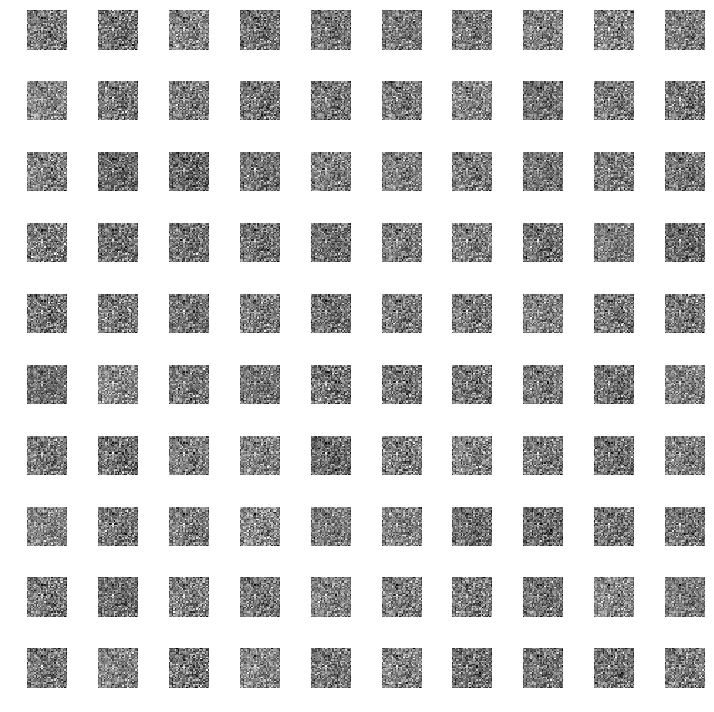

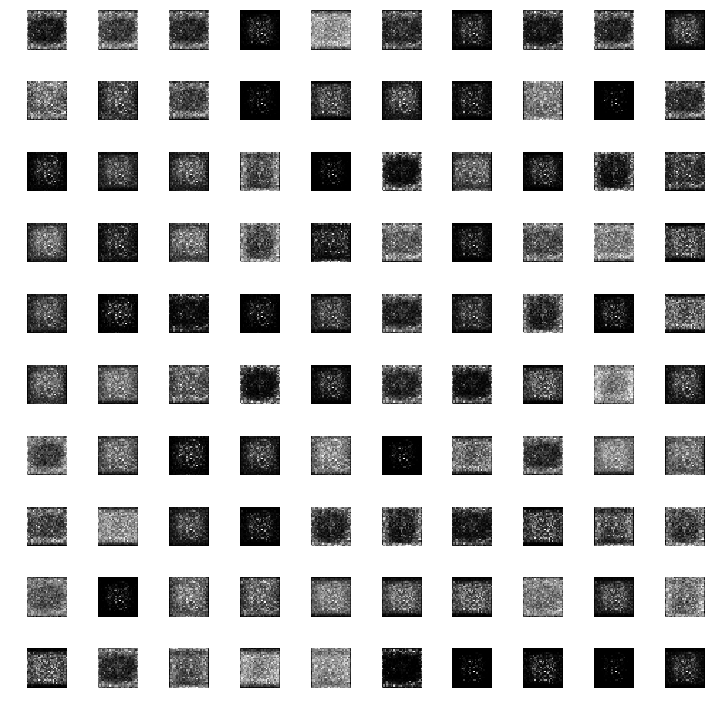

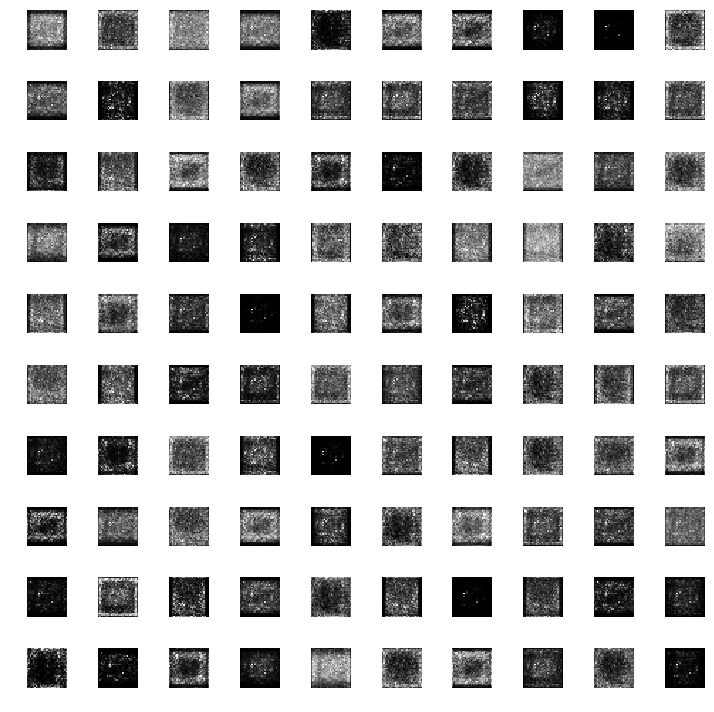

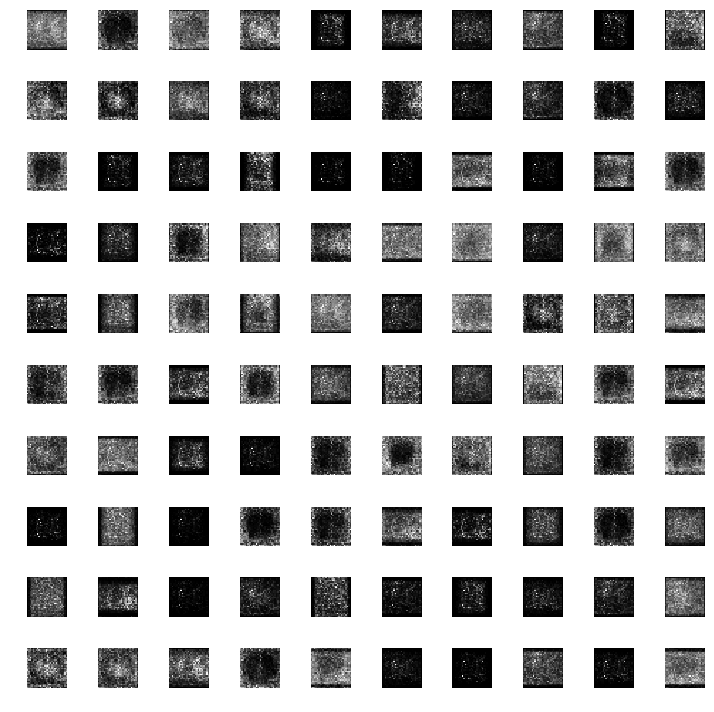

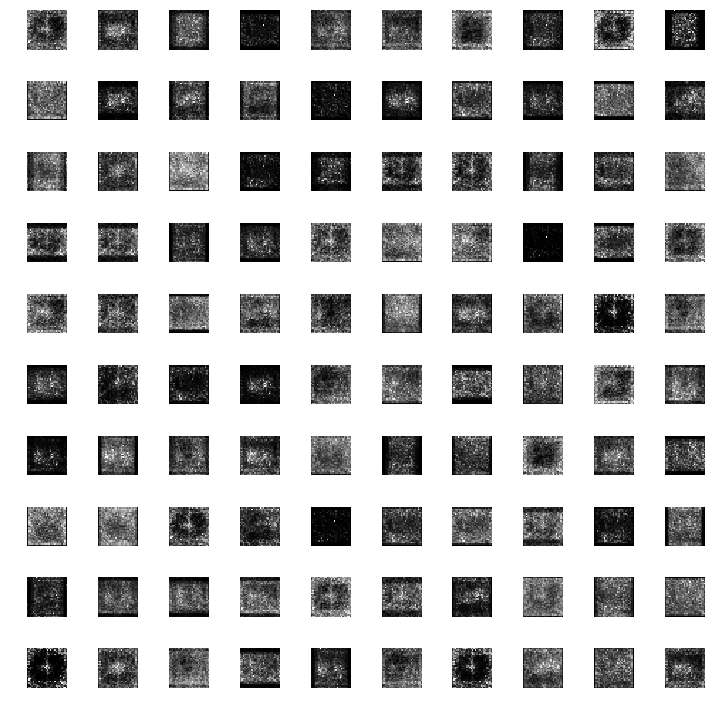

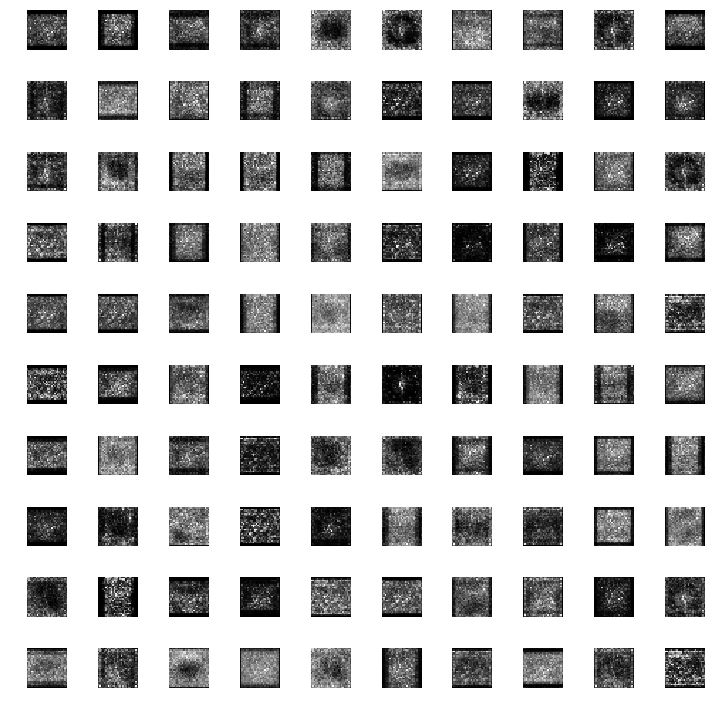

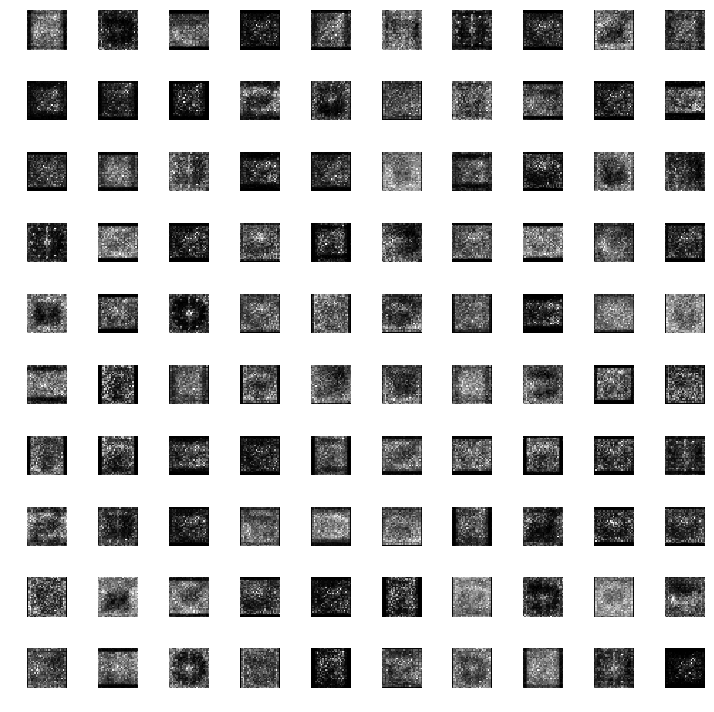

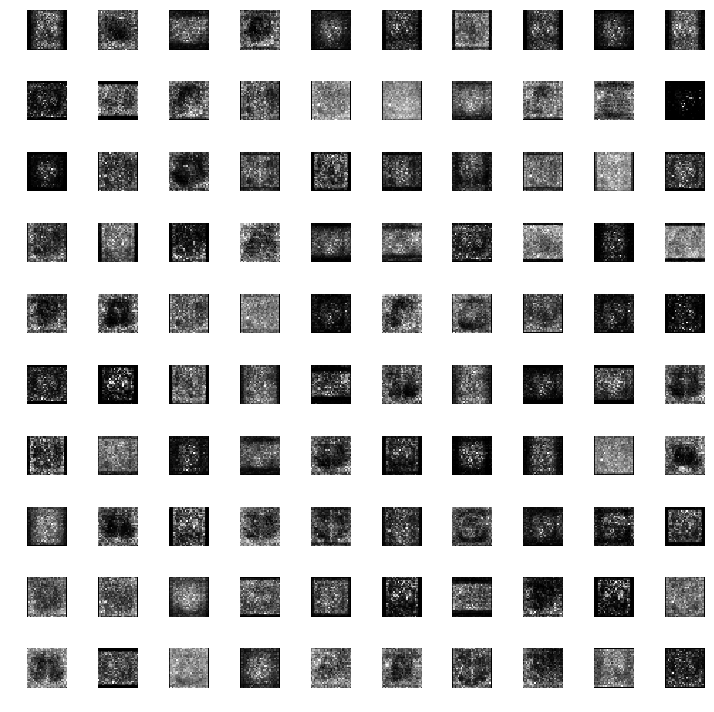

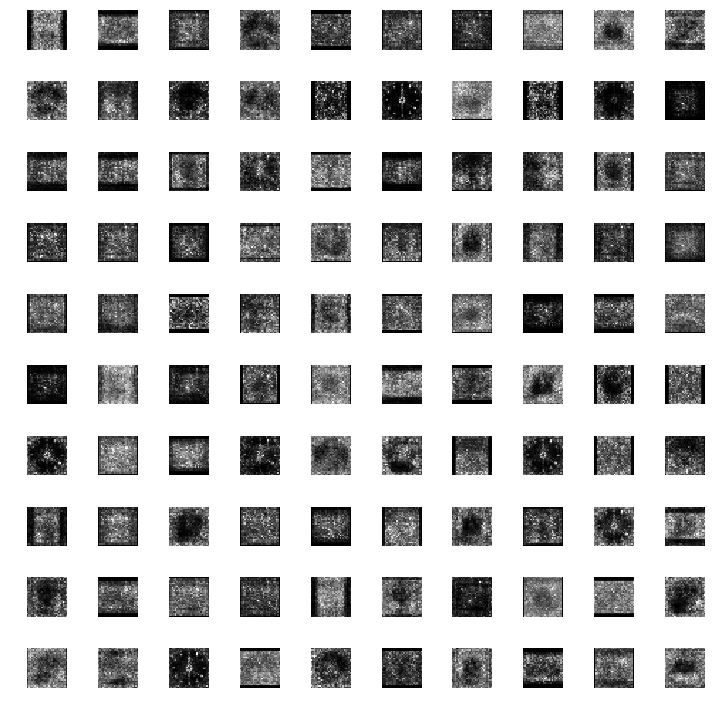

In [32]:
def to_gray(url):
  img = imageio.imread(url)
  gray_img = color.rgb2gray(img)
  return gray_img

emoji_gray = np.array([to_gray('emoji/'+url) for url in listdir('emoji')])

def train_emoji(epochs=1, batch_size=128):
    # Get the training and testing data
    # TODO:
    x_train = emoji_gray
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)].reshape(64, 784)
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 100 == 0:
            plot_generated_images(e, generator)
 
train_emoji(800, 64)

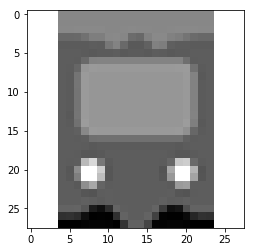

In [33]:
for im in emoji_gray:
  plt.imshow(im, cmap="gray")

(861, 28, 28, 4)
(861, 3136)


  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 13/13 [00:06<00:00,  2.15it/s]
W0724 20:30:01.007333 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:01.021950 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:01.036857 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:01.050097 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:01.062982 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:01.075880 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 2 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.22it/s]

--------------- Epoch 3 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.54it/s]

--------------- Epoch 4 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.96it/s]

--------------- Epoch 5 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.02it/s]

--------------- Epoch 6 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.07it/s]

--------------- Epoch 7 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.14it/s]

--------------- Epoch 8 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.10it/s]

--------------- Epoch 9 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.46it/s]

--------------- Epoch 10 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.91it/s]

--------------- Epoch 11 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.27it/s]

--------------- Epoch 12 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.46it/s]

--------------- Epoch 13 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.76it/s]

--------------- Epoch 14 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.02it/s]

--------------- Epoch 15 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.20it/s]

--------------- Epoch 16 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.68it/s]

--------------- Epoch 17 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.63it/s]

--------------- Epoch 18 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.12it/s]

--------------- Epoch 19 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.41it/s]

--------------- Epoch 20 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.37it/s]

--------------- Epoch 21 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.03it/s]

--------------- Epoch 22 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.06it/s]

--------------- Epoch 23 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.75it/s]

--------------- Epoch 24 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 45.60it/s]

--------------- Epoch 25 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.55it/s]

--------------- Epoch 26 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.28it/s]

--------------- Epoch 27 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.55it/s]

--------------- Epoch 28 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.54it/s]

--------------- Epoch 29 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.76it/s]

--------------- Epoch 30 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.24it/s]

--------------- Epoch 31 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.88it/s]

--------------- Epoch 32 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.35it/s]

--------------- Epoch 33 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.13it/s]

--------------- Epoch 34 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.95it/s]

--------------- Epoch 35 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.84it/s]

--------------- Epoch 36 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.90it/s]

--------------- Epoch 37 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.98it/s]

--------------- Epoch 38 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.70it/s]

--------------- Epoch 39 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.79it/s]

--------------- Epoch 40 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.08it/s]

--------------- Epoch 41 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.10it/s]

--------------- Epoch 42 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.44it/s]

--------------- Epoch 43 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.88it/s]

--------------- Epoch 44 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.86it/s]

--------------- Epoch 45 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.55it/s]

--------------- Epoch 46 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.23it/s]

--------------- Epoch 47 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 48 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.73it/s]

--------------- Epoch 49 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.81it/s]

--------------- Epoch 50 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.16it/s]

--------------- Epoch 51 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.92it/s]

--------------- Epoch 52 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.05it/s]

--------------- Epoch 53 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.32it/s]

--------------- Epoch 54 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.07it/s]

--------------- Epoch 55 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.82it/s]

--------------- Epoch 56 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.63it/s]

--------------- Epoch 57 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.04it/s]

--------------- Epoch 58 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.92it/s]

--------------- Epoch 59 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.13it/s]

--------------- Epoch 60 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.89it/s]

--------------- Epoch 61 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.48it/s]

--------------- Epoch 62 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.00it/s]

--------------- Epoch 63 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.25it/s]

--------------- Epoch 64 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.51it/s]

--------------- Epoch 65 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.18it/s]

--------------- Epoch 66 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.27it/s]

--------------- Epoch 67 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.31it/s]

--------------- Epoch 68 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.42it/s]

--------------- Epoch 69 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.55it/s]

--------------- Epoch 70 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.64it/s]

--------------- Epoch 71 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.98it/s]

--------------- Epoch 72 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.16it/s]

--------------- Epoch 73 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.99it/s]

--------------- Epoch 74 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.72it/s]

--------------- Epoch 75 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.60it/s]

--------------- Epoch 76 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 49.60it/s]

--------------- Epoch 77 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.22it/s]

--------------- Epoch 78 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.60it/s]

--------------- Epoch 79 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.62it/s]

--------------- Epoch 80 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 49.07it/s]

--------------- Epoch 81 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.23it/s]

--------------- Epoch 82 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.56it/s]

--------------- Epoch 83 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.61it/s]

--------------- Epoch 84 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.70it/s]

--------------- Epoch 85 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 86 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.59it/s]

--------------- Epoch 87 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.72it/s]

--------------- Epoch 88 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.26it/s]

--------------- Epoch 89 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.31it/s]

--------------- Epoch 90 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.37it/s]

--------------- Epoch 91 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.02it/s]

--------------- Epoch 92 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.46it/s]

--------------- Epoch 93 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.74it/s]

--------------- Epoch 94 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.96it/s]

--------------- Epoch 95 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.98it/s]

--------------- Epoch 96 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.08it/s]

--------------- Epoch 97 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.02it/s]

--------------- Epoch 98 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.39it/s]

--------------- Epoch 99 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.92it/s]

--------------- Epoch 100 ---------------


100%|██████████| 13/13 [00:00<00:00, 52.35it/s]
W0724 20:30:29.265574 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:29.281322 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:29.296938 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:29.310584 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:29.323374 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:29.335308 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 101 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.63it/s]

--------------- Epoch 102 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.67it/s]

--------------- Epoch 103 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.43it/s]

--------------- Epoch 104 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.76it/s]

--------------- Epoch 105 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.76it/s]

--------------- Epoch 106 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.32it/s]

--------------- Epoch 107 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.43it/s]

--------------- Epoch 108 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.57it/s]

--------------- Epoch 109 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.21it/s]

--------------- Epoch 110 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.23it/s]

--------------- Epoch 111 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.84it/s]

--------------- Epoch 112 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.39it/s]

--------------- Epoch 113 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.40it/s]

--------------- Epoch 114 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.33it/s]

--------------- Epoch 115 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.76it/s]

--------------- Epoch 116 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.22it/s]

--------------- Epoch 117 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.28it/s]

--------------- Epoch 118 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.07it/s]

--------------- Epoch 119 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.49it/s]

--------------- Epoch 120 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.93it/s]

--------------- Epoch 121 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 49.85it/s]

--------------- Epoch 122 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.00it/s]

--------------- Epoch 123 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 44.55it/s]

--------------- Epoch 124 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.94it/s]

--------------- Epoch 125 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.92it/s]

--------------- Epoch 126 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.58it/s]

--------------- Epoch 127 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.79it/s]

--------------- Epoch 128 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.38it/s]

--------------- Epoch 129 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 48.82it/s]

--------------- Epoch 130 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.75it/s]

--------------- Epoch 131 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.52it/s]

--------------- Epoch 132 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.32it/s]

--------------- Epoch 133 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.50it/s]

--------------- Epoch 134 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.96it/s]

--------------- Epoch 135 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.79it/s]

--------------- Epoch 136 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.78it/s]

--------------- Epoch 137 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.30it/s]

--------------- Epoch 138 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.70it/s]

--------------- Epoch 139 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.55it/s]

--------------- Epoch 140 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.54it/s]

--------------- Epoch 141 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.23it/s]

--------------- Epoch 142 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.57it/s]

--------------- Epoch 143 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.63it/s]

--------------- Epoch 144 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.08it/s]

--------------- Epoch 145 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.28it/s]

--------------- Epoch 146 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.06it/s]

--------------- Epoch 147 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.20it/s]

--------------- Epoch 148 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.83it/s]

--------------- Epoch 149 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.89it/s]

--------------- Epoch 150 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.55it/s]

--------------- Epoch 151 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.27it/s]

--------------- Epoch 152 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.57it/s]

--------------- Epoch 153 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.72it/s]

--------------- Epoch 154 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.95it/s]

--------------- Epoch 155 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.57it/s]

--------------- Epoch 156 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.86it/s]

--------------- Epoch 157 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.12it/s]

--------------- Epoch 158 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.42it/s]

--------------- Epoch 159 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.82it/s]

--------------- Epoch 160 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.49it/s]

--------------- Epoch 161 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.92it/s]

--------------- Epoch 162 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.68it/s]

--------------- Epoch 163 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.27it/s]

--------------- Epoch 164 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.88it/s]

--------------- Epoch 165 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.32it/s]

--------------- Epoch 166 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.73it/s]

--------------- Epoch 167 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.03it/s]

--------------- Epoch 168 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.79it/s]

--------------- Epoch 169 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.34it/s]

--------------- Epoch 170 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.87it/s]

--------------- Epoch 171 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.05it/s]

--------------- Epoch 172 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.10it/s]

--------------- Epoch 173 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.43it/s]

--------------- Epoch 174 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.96it/s]

--------------- Epoch 175 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.30it/s]

--------------- Epoch 176 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.49it/s]

--------------- Epoch 177 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.00it/s]

--------------- Epoch 178 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.16it/s]

--------------- Epoch 179 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.83it/s]

--------------- Epoch 180 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.19it/s]

--------------- Epoch 181 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.20it/s]

--------------- Epoch 182 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.57it/s]

--------------- Epoch 183 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.50it/s]

--------------- Epoch 184 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.90it/s]

--------------- Epoch 185 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.84it/s]

--------------- Epoch 186 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.20it/s]

--------------- Epoch 187 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.24it/s]

--------------- Epoch 188 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.05it/s]

--------------- Epoch 189 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.30it/s]

--------------- Epoch 190 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.07it/s]

--------------- Epoch 191 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.72it/s]

--------------- Epoch 192 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.48it/s]

--------------- Epoch 193 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.36it/s]

--------------- Epoch 194 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.89it/s]

--------------- Epoch 195 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.16it/s]

--------------- Epoch 196 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.12it/s]

--------------- Epoch 197 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.64it/s]

--------------- Epoch 198 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.81it/s]

--------------- Epoch 199 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.10it/s]

--------------- Epoch 200 ---------------


100%|██████████| 13/13 [00:00<00:00, 52.11it/s]
W0724 20:30:57.738728 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:57.753899 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:57.766863 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:57.781100 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:57.796393 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:30:57.810350 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 201 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.36it/s]

--------------- Epoch 202 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.50it/s]

--------------- Epoch 203 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.04it/s]

--------------- Epoch 204 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.32it/s]

--------------- Epoch 205 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.48it/s]

--------------- Epoch 206 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.23it/s]

--------------- Epoch 207 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.16it/s]

--------------- Epoch 208 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.15it/s]

--------------- Epoch 209 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.54it/s]

--------------- Epoch 210 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.66it/s]

--------------- Epoch 211 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.22it/s]

--------------- Epoch 212 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.39it/s]

--------------- Epoch 213 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.99it/s]

--------------- Epoch 214 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.71it/s]

--------------- Epoch 215 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.18it/s]

--------------- Epoch 216 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.98it/s]

--------------- Epoch 217 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.13it/s]

--------------- Epoch 218 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.10it/s]

--------------- Epoch 219 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.72it/s]

--------------- Epoch 220 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.46it/s]

--------------- Epoch 221 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.95it/s]

--------------- Epoch 222 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.79it/s]

--------------- Epoch 223 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.75it/s]

--------------- Epoch 224 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.68it/s]

--------------- Epoch 225 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.33it/s]

--------------- Epoch 226 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.83it/s]

--------------- Epoch 227 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.62it/s]

--------------- Epoch 228 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.40it/s]

--------------- Epoch 229 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.20it/s]

--------------- Epoch 230 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.36it/s]

--------------- Epoch 231 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.17it/s]

--------------- Epoch 232 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.59it/s]

--------------- Epoch 233 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.07it/s]

--------------- Epoch 234 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.61it/s]

--------------- Epoch 235 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.66it/s]

--------------- Epoch 236 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.76it/s]

--------------- Epoch 237 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.33it/s]

--------------- Epoch 238 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.52it/s]

--------------- Epoch 239 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.79it/s]

--------------- Epoch 240 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.65it/s]

--------------- Epoch 241 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.94it/s]

--------------- Epoch 242 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.33it/s]

--------------- Epoch 243 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.77it/s]

--------------- Epoch 244 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.77it/s]

--------------- Epoch 245 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.41it/s]

--------------- Epoch 246 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.99it/s]

--------------- Epoch 247 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.81it/s]

--------------- Epoch 248 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.24it/s]

--------------- Epoch 249 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.15it/s]

--------------- Epoch 250 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.85it/s]

--------------- Epoch 251 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.05it/s]

--------------- Epoch 252 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.75it/s]

--------------- Epoch 253 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.65it/s]

--------------- Epoch 254 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.26it/s]

--------------- Epoch 255 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.97it/s]

--------------- Epoch 256 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 257 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.55it/s]

--------------- Epoch 258 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.50it/s]

--------------- Epoch 259 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.29it/s]

--------------- Epoch 260 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.29it/s]

--------------- Epoch 261 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.24it/s]

--------------- Epoch 262 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.18it/s]

--------------- Epoch 263 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.98it/s]

--------------- Epoch 264 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.84it/s]

--------------- Epoch 265 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.21it/s]

--------------- Epoch 266 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.19it/s]

--------------- Epoch 267 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.58it/s]

--------------- Epoch 268 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.94it/s]

--------------- Epoch 269 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.20it/s]

--------------- Epoch 270 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.55it/s]

--------------- Epoch 271 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.67it/s]

--------------- Epoch 272 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.48it/s]

--------------- Epoch 273 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.10it/s]

--------------- Epoch 274 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.73it/s]

--------------- Epoch 275 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.42it/s]

--------------- Epoch 276 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.92it/s]

--------------- Epoch 277 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.37it/s]

--------------- Epoch 278 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.26it/s]

--------------- Epoch 279 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.25it/s]

--------------- Epoch 280 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.99it/s]

--------------- Epoch 281 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.51it/s]

--------------- Epoch 282 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.80it/s]

--------------- Epoch 283 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.07it/s]

--------------- Epoch 284 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.83it/s]

--------------- Epoch 285 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.32it/s]

--------------- Epoch 286 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.27it/s]

--------------- Epoch 287 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.51it/s]

--------------- Epoch 288 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.74it/s]

--------------- Epoch 289 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.50it/s]

--------------- Epoch 290 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.63it/s]

--------------- Epoch 291 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.75it/s]

--------------- Epoch 292 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.18it/s]

--------------- Epoch 293 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.72it/s]

--------------- Epoch 294 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.33it/s]

--------------- Epoch 295 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.02it/s]

--------------- Epoch 296 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.85it/s]

--------------- Epoch 297 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.26it/s]

--------------- Epoch 298 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.12it/s]

--------------- Epoch 299 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.20it/s]

--------------- Epoch 300 ---------------


100%|██████████| 13/13 [00:00<00:00, 53.39it/s]
W0724 20:31:26.054681 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:26.067380 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:26.080677 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:26.095603 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:26.107954 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:26.119201 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 301 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.90it/s]

--------------- Epoch 302 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.28it/s]

--------------- Epoch 303 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.46it/s]

--------------- Epoch 304 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.90it/s]

--------------- Epoch 305 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.37it/s]

--------------- Epoch 306 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.64it/s]

--------------- Epoch 307 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.66it/s]

--------------- Epoch 308 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.32it/s]

--------------- Epoch 309 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.10it/s]

--------------- Epoch 310 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.15it/s]

--------------- Epoch 311 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.86it/s]

--------------- Epoch 312 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.05it/s]

--------------- Epoch 313 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.20it/s]

--------------- Epoch 314 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.48it/s]

--------------- Epoch 315 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.08it/s]

--------------- Epoch 316 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.74it/s]

--------------- Epoch 317 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.46it/s]

--------------- Epoch 318 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.89it/s]

--------------- Epoch 319 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.85it/s]

--------------- Epoch 320 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.86it/s]

--------------- Epoch 321 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.61it/s]

--------------- Epoch 322 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.96it/s]

--------------- Epoch 323 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.54it/s]

--------------- Epoch 324 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.75it/s]

--------------- Epoch 325 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.12it/s]

--------------- Epoch 326 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.76it/s]

--------------- Epoch 327 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.73it/s]

--------------- Epoch 328 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.54it/s]

--------------- Epoch 329 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.28it/s]

--------------- Epoch 330 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.98it/s]

--------------- Epoch 331 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.62it/s]

--------------- Epoch 332 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.40it/s]

--------------- Epoch 333 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.43it/s]

--------------- Epoch 334 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.21it/s]

--------------- Epoch 335 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.53it/s]

--------------- Epoch 336 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.21it/s]

--------------- Epoch 337 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.03it/s]

--------------- Epoch 338 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.71it/s]

--------------- Epoch 339 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.25it/s]

--------------- Epoch 340 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.27it/s]

--------------- Epoch 341 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.08it/s]

--------------- Epoch 342 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.18it/s]

--------------- Epoch 343 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.75it/s]

--------------- Epoch 344 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.01it/s]

--------------- Epoch 345 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.29it/s]

--------------- Epoch 346 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.11it/s]

--------------- Epoch 347 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.36it/s]

--------------- Epoch 348 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.69it/s]

--------------- Epoch 349 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.70it/s]

--------------- Epoch 350 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.84it/s]

--------------- Epoch 351 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.85it/s]

--------------- Epoch 352 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.40it/s]

--------------- Epoch 353 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.19it/s]

--------------- Epoch 354 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.25it/s]

--------------- Epoch 355 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.07it/s]

--------------- Epoch 356 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.23it/s]

--------------- Epoch 357 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.60it/s]

--------------- Epoch 358 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.24it/s]

--------------- Epoch 359 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.21it/s]

--------------- Epoch 360 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.75it/s]

--------------- Epoch 361 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.42it/s]

--------------- Epoch 362 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.49it/s]

--------------- Epoch 363 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.88it/s]

--------------- Epoch 364 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.00it/s]

--------------- Epoch 365 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.57it/s]

--------------- Epoch 366 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.11it/s]

--------------- Epoch 367 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.08it/s]

--------------- Epoch 368 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.85it/s]

--------------- Epoch 369 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.49it/s]

--------------- Epoch 370 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.35it/s]

--------------- Epoch 371 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.72it/s]

--------------- Epoch 372 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.57it/s]

--------------- Epoch 373 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.83it/s]

--------------- Epoch 374 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.88it/s]

--------------- Epoch 375 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.03it/s]

--------------- Epoch 376 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.87it/s]

--------------- Epoch 377 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.73it/s]

--------------- Epoch 378 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.80it/s]

--------------- Epoch 379 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.84it/s]

--------------- Epoch 380 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.08it/s]

--------------- Epoch 381 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.90it/s]

--------------- Epoch 382 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.70it/s]

--------------- Epoch 383 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.42it/s]

--------------- Epoch 384 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.02it/s]

--------------- Epoch 385 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.32it/s]

--------------- Epoch 386 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.63it/s]

--------------- Epoch 387 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.26it/s]

--------------- Epoch 388 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.00it/s]

--------------- Epoch 389 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.57it/s]

--------------- Epoch 390 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.96it/s]

--------------- Epoch 391 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.50it/s]

--------------- Epoch 392 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.98it/s]

--------------- Epoch 393 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.38it/s]

--------------- Epoch 394 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.08it/s]

--------------- Epoch 395 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.31it/s]

--------------- Epoch 396 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.53it/s]

--------------- Epoch 397 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.43it/s]

--------------- Epoch 398 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.90it/s]

--------------- Epoch 399 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.17it/s]

--------------- Epoch 400 ---------------


100%|██████████| 13/13 [00:00<00:00, 54.07it/s]
W0724 20:31:56.810177 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:56.823371 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:56.837002 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:56.851145 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:56.864001 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:31:56.881820 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 401 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.89it/s]

--------------- Epoch 402 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 42.85it/s]

--------------- Epoch 403 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.55it/s]

--------------- Epoch 404 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.46it/s]

--------------- Epoch 405 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.56it/s]

--------------- Epoch 406 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.72it/s]

--------------- Epoch 407 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.47it/s]

--------------- Epoch 408 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.87it/s]

--------------- Epoch 409 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.83it/s]

--------------- Epoch 410 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.90it/s]

--------------- Epoch 411 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.42it/s]

--------------- Epoch 412 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.35it/s]

--------------- Epoch 413 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.42it/s]

--------------- Epoch 414 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.11it/s]

--------------- Epoch 415 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.74it/s]

--------------- Epoch 416 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.29it/s]

--------------- Epoch 417 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.85it/s]

--------------- Epoch 418 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.73it/s]

--------------- Epoch 419 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.51it/s]

--------------- Epoch 420 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.11it/s]

--------------- Epoch 421 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.08it/s]

--------------- Epoch 422 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.49it/s]

--------------- Epoch 423 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.30it/s]

--------------- Epoch 424 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.05it/s]

--------------- Epoch 425 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.63it/s]

--------------- Epoch 426 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.04it/s]

--------------- Epoch 427 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.94it/s]

--------------- Epoch 428 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.58it/s]

--------------- Epoch 429 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.39it/s]

--------------- Epoch 430 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.04it/s]

--------------- Epoch 431 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.48it/s]

--------------- Epoch 432 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.23it/s]

--------------- Epoch 433 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.93it/s]

--------------- Epoch 434 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.14it/s]

--------------- Epoch 435 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.50it/s]

--------------- Epoch 436 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.55it/s]

--------------- Epoch 437 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.28it/s]

--------------- Epoch 438 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.59it/s]

--------------- Epoch 439 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.25it/s]

--------------- Epoch 440 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.02it/s]

--------------- Epoch 441 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.74it/s]

--------------- Epoch 442 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.45it/s]

--------------- Epoch 443 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.36it/s]

--------------- Epoch 444 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.25it/s]

--------------- Epoch 445 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.60it/s]

--------------- Epoch 446 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.62it/s]

--------------- Epoch 447 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.39it/s]

--------------- Epoch 448 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.88it/s]

--------------- Epoch 449 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.85it/s]

--------------- Epoch 450 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.82it/s]

--------------- Epoch 451 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.99it/s]

--------------- Epoch 452 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.95it/s]

--------------- Epoch 453 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.99it/s]

--------------- Epoch 454 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.93it/s]

--------------- Epoch 455 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.02it/s]

--------------- Epoch 456 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.68it/s]

--------------- Epoch 457 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.58it/s]

--------------- Epoch 458 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.40it/s]

--------------- Epoch 459 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.55it/s]

--------------- Epoch 460 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.41it/s]

--------------- Epoch 461 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.57it/s]

--------------- Epoch 462 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.95it/s]

--------------- Epoch 463 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.71it/s]

--------------- Epoch 464 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.38it/s]

--------------- Epoch 465 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.19it/s]

--------------- Epoch 466 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.41it/s]

--------------- Epoch 467 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.79it/s]

--------------- Epoch 468 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.20it/s]

--------------- Epoch 469 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.30it/s]

--------------- Epoch 470 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.26it/s]

--------------- Epoch 471 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.00it/s]

--------------- Epoch 472 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.90it/s]

--------------- Epoch 473 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.11it/s]

--------------- Epoch 474 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.13it/s]

--------------- Epoch 475 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.33it/s]

--------------- Epoch 476 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.52it/s]

--------------- Epoch 477 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.53it/s]

--------------- Epoch 478 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.43it/s]

--------------- Epoch 479 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.34it/s]

--------------- Epoch 480 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.04it/s]

--------------- Epoch 481 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.62it/s]

--------------- Epoch 482 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.53it/s]

--------------- Epoch 483 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.37it/s]

--------------- Epoch 484 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.94it/s]

--------------- Epoch 485 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.68it/s]

--------------- Epoch 486 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.99it/s]

--------------- Epoch 487 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.64it/s]

--------------- Epoch 488 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.62it/s]

--------------- Epoch 489 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.81it/s]

--------------- Epoch 490 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.04it/s]

--------------- Epoch 491 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.48it/s]

--------------- Epoch 492 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.38it/s]

--------------- Epoch 493 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.02it/s]

--------------- Epoch 494 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.12it/s]

--------------- Epoch 495 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.91it/s]

--------------- Epoch 496 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.89it/s]

--------------- Epoch 497 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.02it/s]

--------------- Epoch 498 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.95it/s]

--------------- Epoch 499 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.45it/s]

--------------- Epoch 500 ---------------


100%|██████████| 13/13 [00:00<00:00, 50.79it/s]
W0724 20:32:25.088099 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:25.102186 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:25.114329 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:25.127522 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:25.140486 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:25.151733 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 501 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.41it/s]

--------------- Epoch 502 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.88it/s]

--------------- Epoch 503 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.89it/s]

--------------- Epoch 504 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.54it/s]

--------------- Epoch 505 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.64it/s]

--------------- Epoch 506 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 507 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.87it/s]

--------------- Epoch 508 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.22it/s]

--------------- Epoch 509 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.56it/s]

--------------- Epoch 510 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.55it/s]

--------------- Epoch 511 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.24it/s]

--------------- Epoch 512 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.90it/s]

--------------- Epoch 513 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 514 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.62it/s]

--------------- Epoch 515 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.64it/s]

--------------- Epoch 516 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.09it/s]

--------------- Epoch 517 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.21it/s]

--------------- Epoch 518 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.64it/s]

--------------- Epoch 519 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.95it/s]

--------------- Epoch 520 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.34it/s]

--------------- Epoch 521 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.02it/s]

--------------- Epoch 522 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.52it/s]

--------------- Epoch 523 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.96it/s]

--------------- Epoch 524 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.95it/s]

--------------- Epoch 525 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.95it/s]

--------------- Epoch 526 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.08it/s]

--------------- Epoch 527 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.54it/s]

--------------- Epoch 528 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.45it/s]

--------------- Epoch 529 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 530 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.88it/s]

--------------- Epoch 531 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.87it/s]

--------------- Epoch 532 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.74it/s]

--------------- Epoch 533 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.22it/s]

--------------- Epoch 534 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.15it/s]

--------------- Epoch 535 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.39it/s]

--------------- Epoch 536 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.24it/s]

--------------- Epoch 537 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.53it/s]

--------------- Epoch 538 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.75it/s]

--------------- Epoch 539 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.82it/s]

--------------- Epoch 540 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.22it/s]

--------------- Epoch 541 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.59it/s]

--------------- Epoch 542 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.75it/s]

--------------- Epoch 543 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.68it/s]

--------------- Epoch 544 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.21it/s]

--------------- Epoch 545 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.33it/s]

--------------- Epoch 546 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.03it/s]

--------------- Epoch 547 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.71it/s]

--------------- Epoch 548 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.13it/s]

--------------- Epoch 549 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.42it/s]

--------------- Epoch 550 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.50it/s]

--------------- Epoch 551 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.50it/s]

--------------- Epoch 552 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.84it/s]

--------------- Epoch 553 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 48.52it/s]

--------------- Epoch 554 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.52it/s]

--------------- Epoch 555 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.48it/s]

--------------- Epoch 556 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.21it/s]

--------------- Epoch 557 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.54it/s]

--------------- Epoch 558 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.86it/s]

--------------- Epoch 559 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.14it/s]

--------------- Epoch 560 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 48.06it/s]

--------------- Epoch 561 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.21it/s]

--------------- Epoch 562 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.76it/s]

--------------- Epoch 563 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.13it/s]

--------------- Epoch 564 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.75it/s]

--------------- Epoch 565 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.70it/s]

--------------- Epoch 566 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.63it/s]

--------------- Epoch 567 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.09it/s]

--------------- Epoch 568 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.25it/s]

--------------- Epoch 569 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.26it/s]

--------------- Epoch 570 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.80it/s]

--------------- Epoch 571 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.27it/s]

--------------- Epoch 572 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.68it/s]

--------------- Epoch 573 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.04it/s]

--------------- Epoch 574 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.40it/s]

--------------- Epoch 575 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.98it/s]

--------------- Epoch 576 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.54it/s]

--------------- Epoch 577 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.07it/s]

--------------- Epoch 578 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.06it/s]

--------------- Epoch 579 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.30it/s]

--------------- Epoch 580 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.89it/s]

--------------- Epoch 581 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.02it/s]

--------------- Epoch 582 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.76it/s]

--------------- Epoch 583 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.08it/s]

--------------- Epoch 584 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.88it/s]

--------------- Epoch 585 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.90it/s]

--------------- Epoch 586 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.36it/s]

--------------- Epoch 587 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.17it/s]

--------------- Epoch 588 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.46it/s]

--------------- Epoch 589 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.20it/s]

--------------- Epoch 590 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.23it/s]

--------------- Epoch 591 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.51it/s]

--------------- Epoch 592 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.40it/s]

--------------- Epoch 593 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.60it/s]

--------------- Epoch 594 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.34it/s]

--------------- Epoch 595 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.98it/s]

--------------- Epoch 596 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.74it/s]

--------------- Epoch 597 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 47.64it/s]

--------------- Epoch 598 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.13it/s]

--------------- Epoch 599 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.48it/s]

--------------- Epoch 600 ---------------


100%|██████████| 13/13 [00:00<00:00, 54.56it/s]
W0724 20:32:53.127254 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:53.140937 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:53.153289 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:53.165510 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:53.177088 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:32:53.188271 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 601 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.12it/s]

--------------- Epoch 602 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 49.98it/s]

--------------- Epoch 603 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.47it/s]

--------------- Epoch 604 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.22it/s]

--------------- Epoch 605 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.06it/s]

--------------- Epoch 606 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.84it/s]

--------------- Epoch 607 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.55it/s]

--------------- Epoch 608 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.72it/s]

--------------- Epoch 609 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.51it/s]

--------------- Epoch 610 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.99it/s]

--------------- Epoch 611 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.85it/s]

--------------- Epoch 612 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.22it/s]

--------------- Epoch 613 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.50it/s]

--------------- Epoch 614 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.73it/s]

--------------- Epoch 615 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.45it/s]

--------------- Epoch 616 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.16it/s]

--------------- Epoch 617 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.81it/s]

--------------- Epoch 618 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.52it/s]

--------------- Epoch 619 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.00it/s]

--------------- Epoch 620 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.51it/s]

--------------- Epoch 621 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.49it/s]

--------------- Epoch 622 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.68it/s]

--------------- Epoch 623 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.48it/s]

--------------- Epoch 624 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.21it/s]

--------------- Epoch 625 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.47it/s]

--------------- Epoch 626 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.01it/s]

--------------- Epoch 627 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.76it/s]

--------------- Epoch 628 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.80it/s]

--------------- Epoch 629 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.51it/s]

--------------- Epoch 630 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.92it/s]

--------------- Epoch 631 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.67it/s]

--------------- Epoch 632 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.52it/s]

--------------- Epoch 633 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.98it/s]

--------------- Epoch 634 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.05it/s]

--------------- Epoch 635 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.32it/s]

--------------- Epoch 636 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.93it/s]

--------------- Epoch 637 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.46it/s]

--------------- Epoch 638 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.33it/s]

--------------- Epoch 639 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.89it/s]

--------------- Epoch 640 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.92it/s]

--------------- Epoch 641 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.26it/s]

--------------- Epoch 642 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.90it/s]

--------------- Epoch 643 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.22it/s]

--------------- Epoch 644 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.34it/s]

--------------- Epoch 645 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.71it/s]

--------------- Epoch 646 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.14it/s]

--------------- Epoch 647 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.96it/s]

--------------- Epoch 648 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.16it/s]

--------------- Epoch 649 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.20it/s]

--------------- Epoch 650 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.30it/s]

--------------- Epoch 651 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.78it/s]

--------------- Epoch 652 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.67it/s]

--------------- Epoch 653 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.62it/s]

--------------- Epoch 654 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.16it/s]

--------------- Epoch 655 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.12it/s]

--------------- Epoch 656 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.27it/s]

--------------- Epoch 657 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.16it/s]

--------------- Epoch 658 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.87it/s]

--------------- Epoch 659 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.17it/s]

--------------- Epoch 660 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.68it/s]

--------------- Epoch 661 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.14it/s]

--------------- Epoch 662 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.39it/s]

--------------- Epoch 663 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.98it/s]

--------------- Epoch 664 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.89it/s]

--------------- Epoch 665 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.02it/s]

--------------- Epoch 666 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.93it/s]

--------------- Epoch 667 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.22it/s]

--------------- Epoch 668 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.64it/s]

--------------- Epoch 669 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.53it/s]

--------------- Epoch 670 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.28it/s]

--------------- Epoch 671 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.70it/s]

--------------- Epoch 672 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.10it/s]

--------------- Epoch 673 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.37it/s]

--------------- Epoch 674 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.24it/s]

--------------- Epoch 675 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.98it/s]

--------------- Epoch 676 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.44it/s]

--------------- Epoch 677 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.91it/s]

--------------- Epoch 678 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.29it/s]

--------------- Epoch 679 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.64it/s]

--------------- Epoch 680 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.63it/s]

--------------- Epoch 681 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.31it/s]

--------------- Epoch 682 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.77it/s]

--------------- Epoch 683 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.16it/s]

--------------- Epoch 684 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.61it/s]

--------------- Epoch 685 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.65it/s]

--------------- Epoch 686 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.92it/s]

--------------- Epoch 687 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.51it/s]

--------------- Epoch 688 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.27it/s]

--------------- Epoch 689 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.37it/s]

--------------- Epoch 690 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.66it/s]

--------------- Epoch 691 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.30it/s]

--------------- Epoch 692 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.21it/s]

--------------- Epoch 693 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.92it/s]

--------------- Epoch 694 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.30it/s]

--------------- Epoch 695 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.77it/s]

--------------- Epoch 696 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.17it/s]

--------------- Epoch 697 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.73it/s]

--------------- Epoch 698 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 46.73it/s]

--------------- Epoch 699 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.33it/s]

--------------- Epoch 700 ---------------


100%|██████████| 13/13 [00:00<00:00, 54.56it/s]
W0724 20:33:20.651911 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:20.664863 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:20.678774 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:20.690302 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:20.703466 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:20.715339 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

--------------- Epoch 701 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.20it/s]

--------------- Epoch 702 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.02it/s]

--------------- Epoch 703 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 45.16it/s]

--------------- Epoch 704 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.92it/s]

--------------- Epoch 705 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.67it/s]

--------------- Epoch 706 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.30it/s]

--------------- Epoch 707 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.38it/s]

--------------- Epoch 708 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.68it/s]

--------------- Epoch 709 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.95it/s]

--------------- Epoch 710 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.76it/s]

--------------- Epoch 711 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.24it/s]

--------------- Epoch 712 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.46it/s]

--------------- Epoch 713 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.28it/s]

--------------- Epoch 714 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.74it/s]

--------------- Epoch 715 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.83it/s]

--------------- Epoch 716 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.33it/s]

--------------- Epoch 717 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.37it/s]

--------------- Epoch 718 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.58it/s]

--------------- Epoch 719 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.19it/s]

--------------- Epoch 720 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.36it/s]

--------------- Epoch 721 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.75it/s]

--------------- Epoch 722 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.83it/s]

--------------- Epoch 723 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.86it/s]

--------------- Epoch 724 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.42it/s]

--------------- Epoch 725 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.24it/s]

--------------- Epoch 726 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.24it/s]

--------------- Epoch 727 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.16it/s]

--------------- Epoch 728 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.68it/s]

--------------- Epoch 729 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.33it/s]

--------------- Epoch 730 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.92it/s]

--------------- Epoch 731 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.31it/s]

--------------- Epoch 732 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.11it/s]

--------------- Epoch 733 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 57.06it/s]

--------------- Epoch 734 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.87it/s]

--------------- Epoch 735 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 58.16it/s]

--------------- Epoch 736 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.67it/s]

--------------- Epoch 737 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.09it/s]

--------------- Epoch 738 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.92it/s]

--------------- Epoch 739 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.42it/s]

--------------- Epoch 740 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.95it/s]

--------------- Epoch 741 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.11it/s]

--------------- Epoch 742 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.58it/s]

--------------- Epoch 743 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.03it/s]

--------------- Epoch 744 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.28it/s]

--------------- Epoch 745 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.24it/s]

--------------- Epoch 746 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.99it/s]

--------------- Epoch 747 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.90it/s]

--------------- Epoch 748 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.00it/s]

--------------- Epoch 749 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.54it/s]

--------------- Epoch 750 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.13it/s]

--------------- Epoch 751 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.41it/s]

--------------- Epoch 752 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.54it/s]

--------------- Epoch 753 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.52it/s]

--------------- Epoch 754 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.99it/s]

--------------- Epoch 755 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.12it/s]

--------------- Epoch 756 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.93it/s]

--------------- Epoch 757 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.44it/s]

--------------- Epoch 758 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.49it/s]

--------------- Epoch 759 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.37it/s]

--------------- Epoch 760 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.85it/s]

--------------- Epoch 761 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.71it/s]

--------------- Epoch 762 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.24it/s]

--------------- Epoch 763 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.37it/s]

--------------- Epoch 764 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.69it/s]

--------------- Epoch 765 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.65it/s]

--------------- Epoch 766 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.13it/s]

--------------- Epoch 767 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.83it/s]

--------------- Epoch 768 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.52it/s]

--------------- Epoch 769 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.78it/s]

--------------- Epoch 770 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.78it/s]

--------------- Epoch 771 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.76it/s]

--------------- Epoch 772 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.09it/s]

--------------- Epoch 773 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.72it/s]

--------------- Epoch 774 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.09it/s]

--------------- Epoch 775 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.52it/s]

--------------- Epoch 776 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.58it/s]

--------------- Epoch 777 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.19it/s]

--------------- Epoch 778 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.62it/s]

--------------- Epoch 779 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 51.05it/s]

--------------- Epoch 780 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.25it/s]

--------------- Epoch 781 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.36it/s]

--------------- Epoch 782 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 49.87it/s]

--------------- Epoch 783 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.19it/s]

--------------- Epoch 784 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.57it/s]

--------------- Epoch 785 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.59it/s]

--------------- Epoch 786 ---------------


 38%|███▊      | 5/13 [00:00<00:00, 48.29it/s]

--------------- Epoch 787 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.25it/s]

--------------- Epoch 788 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.43it/s]

--------------- Epoch 789 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.35it/s]

--------------- Epoch 790 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 50.25it/s]

--------------- Epoch 791 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.37it/s]

--------------- Epoch 792 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.39it/s]

--------------- Epoch 793 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.42it/s]

--------------- Epoch 794 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.42it/s]

--------------- Epoch 795 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 53.29it/s]

--------------- Epoch 796 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 54.27it/s]

--------------- Epoch 797 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 56.66it/s]

--------------- Epoch 798 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 55.70it/s]

--------------- Epoch 799 ---------------


 46%|████▌     | 6/13 [00:00<00:00, 52.89it/s]

--------------- Epoch 800 ---------------


100%|██████████| 13/13 [00:00<00:00, 49.89it/s]
W0724 20:33:48.349791 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:48.364795 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:48.381564 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:48.397624 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:48.410552 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0724 20:33:48.422363 140644505704320 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

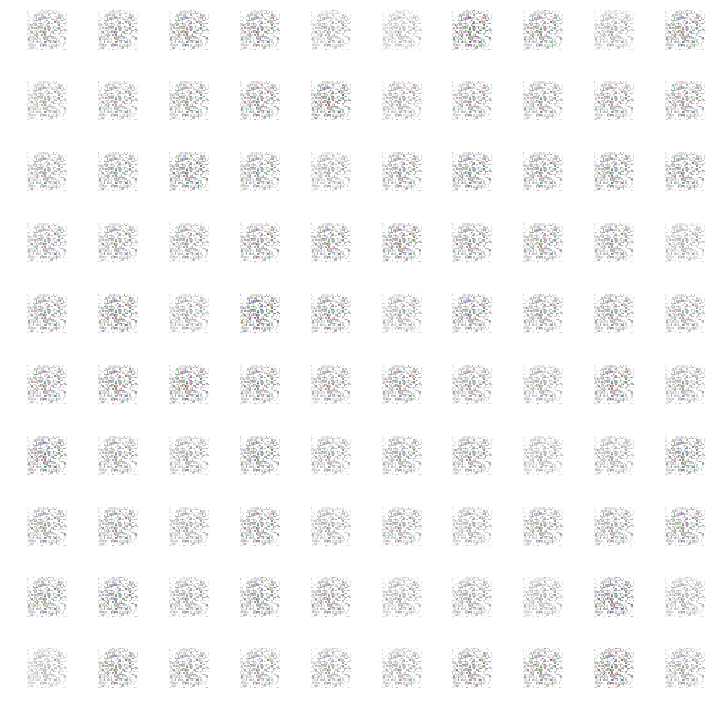

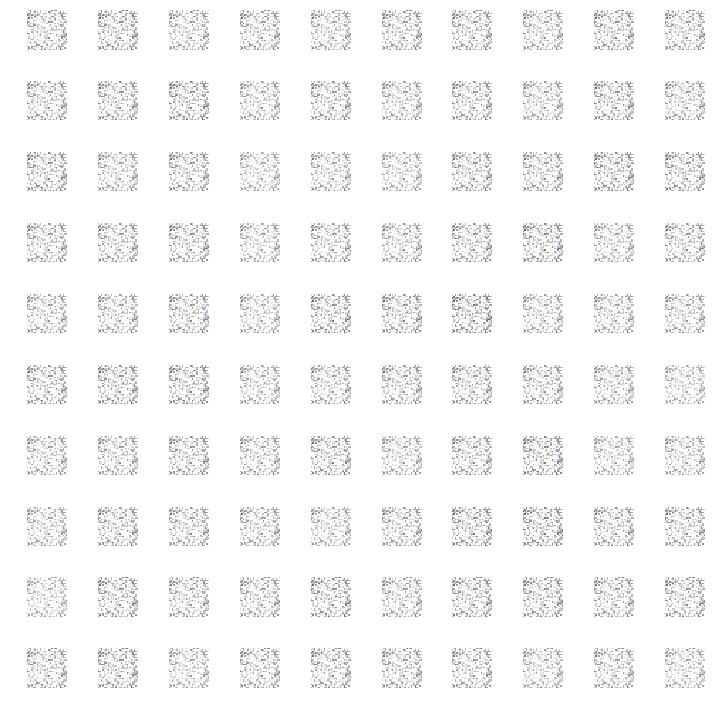

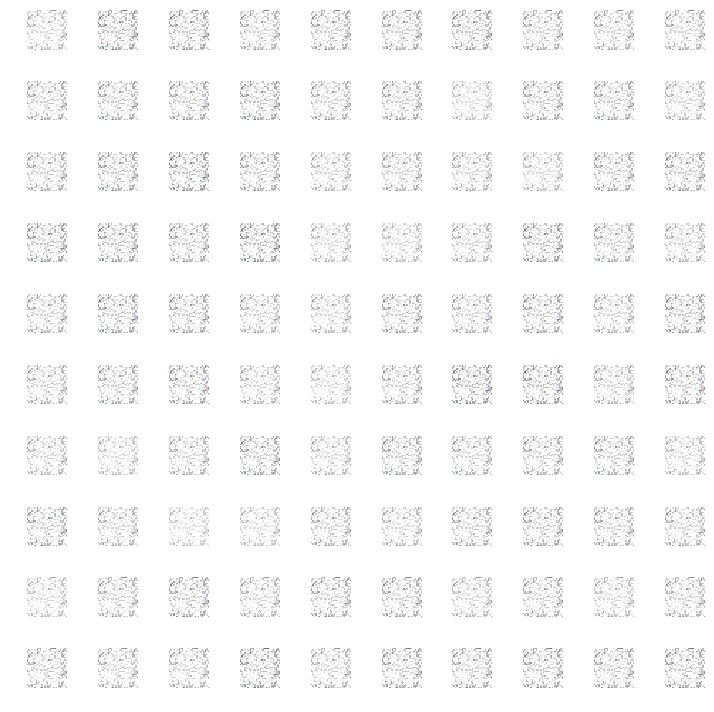

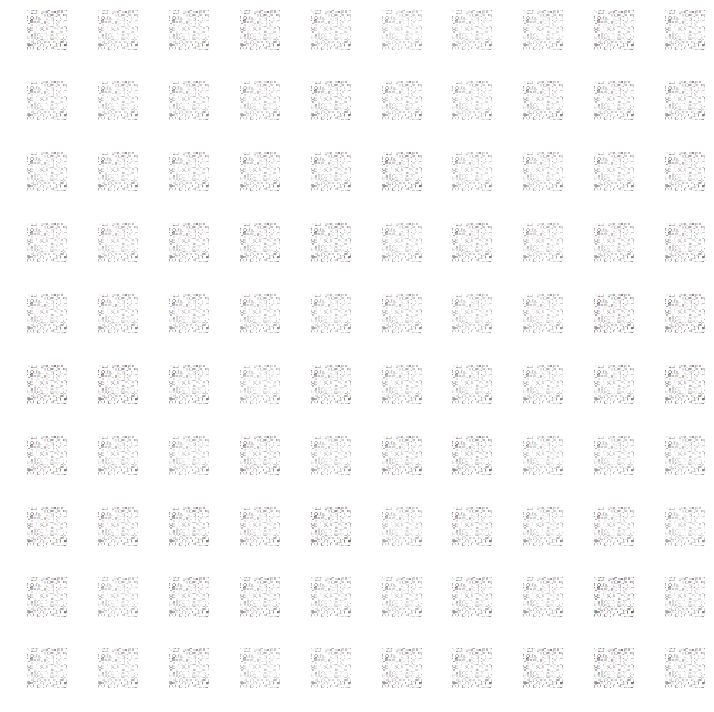

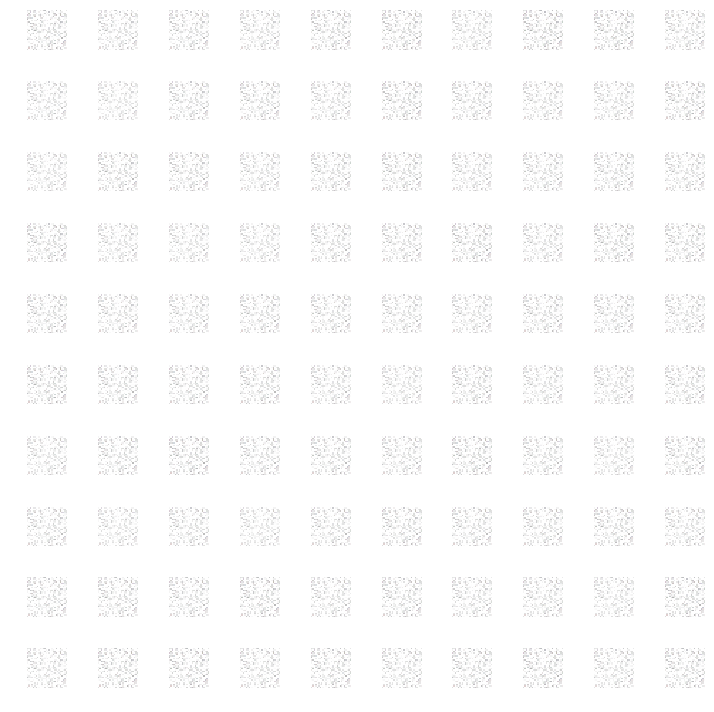

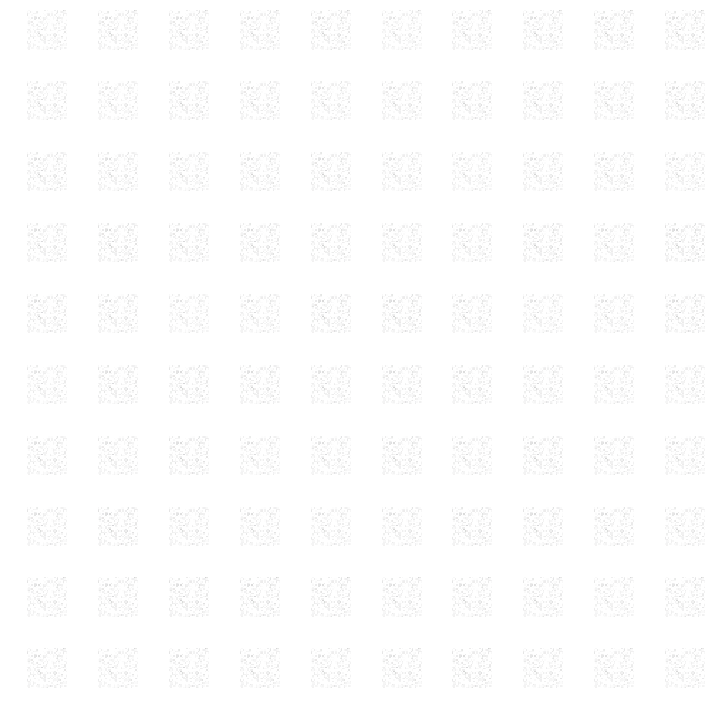

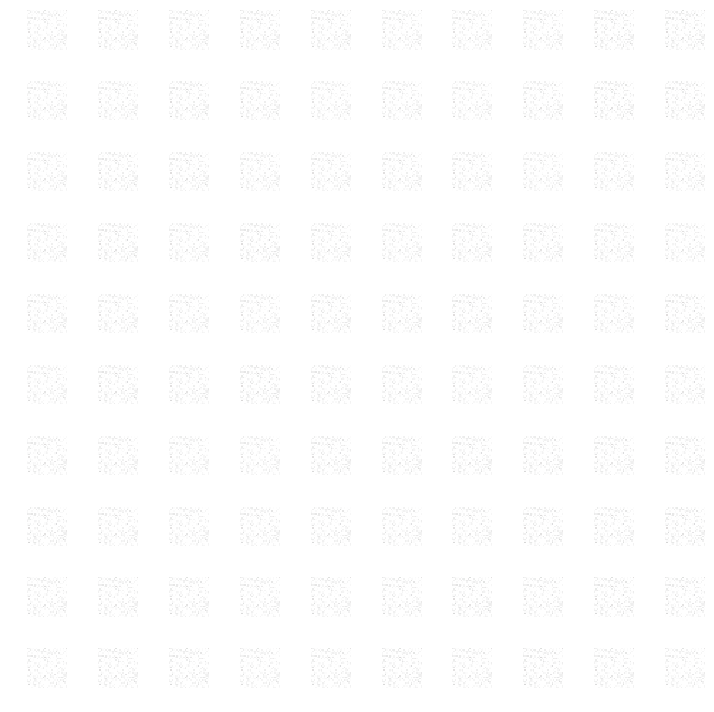

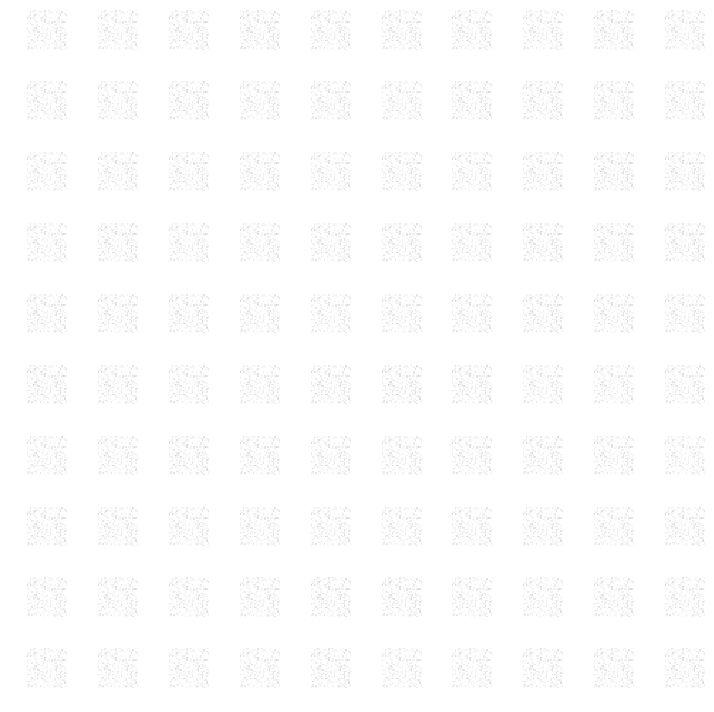

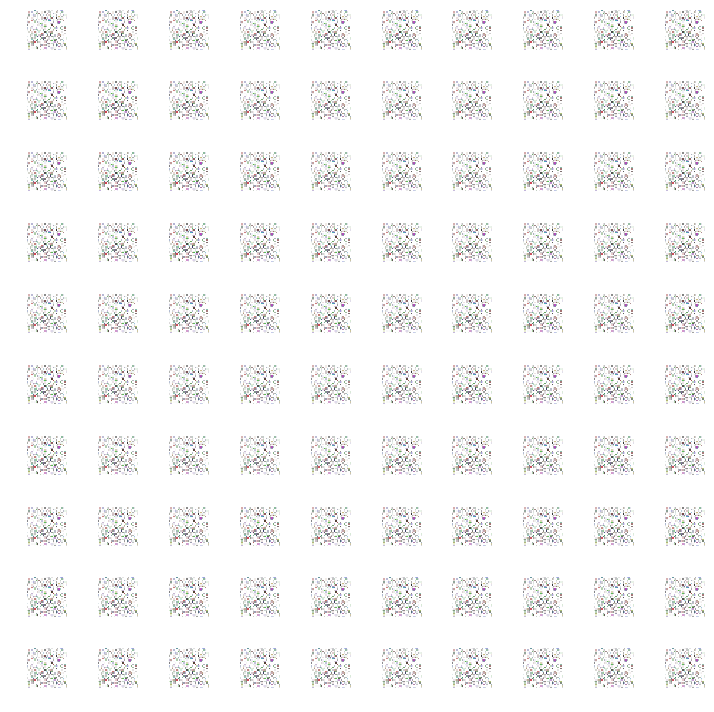

In [53]:
def to_gray(url):
  img = imageio.imread(url)
  gray_img = color.rgb2gray(img)
  return gray_img

emoji_gray = np.array([to_gray('emoji/'+url) for url in listdir('emoji')])

def to_img(url):
  img = imageio.imread(url)
  return img

emoji_color = np.array([to_img('emoji/'+url) for url in listdir('emoji')])

def train_color_emoji(epochs=1, batch_size=128):
    # Get the training and testing data
    
    x_train = emoji_color
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_color_generator(adam)
    discriminator = get_color_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)].reshape(64, -1)
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
#             print(image_batch.shape)
#             print(generated_images.shape)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 100 == 0:
            plot_generated_color_images(e, generator)
 
train_color_emoji(800, 64)

In [0]:
# Refactor for generating emoji with color

def get_color_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(3136, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator
  
def get_color_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=3136,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator
  
def plot_generated_color_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 4)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='RdYlBu')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji